# Text Classification and Topic Modelling

**Author:**  Juan Gordyn

## Part 1:  Text Classification

### 1.1 Introduction

The aim of this task is to build text binary classifiers for 3 individual classes: 'InfoTheory', 'CompVis', 'Math', trying different options for pre-processing techniques in order to analyse and find out which is the combination that yields the highest performance.

To achiveve the completion of this task, we can divide our work in the following sections:

* Statistical Methods: we will first train and test the data using 4 different statistical classification algorithms from which we will choose the best 2 to tune the hyperparameters and finally we will end up keeping the one with the highest performance. The selected algorithm will be tested on 2 different pre-processing configurations, using only the first 1000 cases of the training set and then the entire data.

* RNN LSTM Method: We will use Glove pre-trained word embeddings and will first train the Neural Network and test it on validation set to discover the optimal number of epochs for each classifier. Finally, we will end up training on the whole train set and testing on test set. This will be performed on 2 different pre-processing configurations as well.

* BERT-based model: We are going to make use of the 12-layer BERT model, with an uncased vocab and one extra classification layer on top. Because of computational (and time) constraints, we are going to directly train the model on the entire training set using 2 epochs as recommended by the authors. We will also try just one pre-processing configuration in this case.

* Comparing the 3 different configuration's performance using metrics such as precision, recall and F1score.

* Plotting Precision-Recall curve to help deepen the comparison between models.

* Conclusion.

### 1.2 Importing the libraries

We will be mainly using nltk for pre-processing, sklearn for the statistical methods and calculating the metrics, torch for the RNN LSTM Method, BERT and Torch for the BERT-based method and matplotlib for the plots.

In [ ]:
import sklearn
from itertools import chain
from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
import nltk
import pandas as pd
from itertools import chain
from nltk.probability import *
from nltk.collocations import *
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from nltk.tokenize import MWETokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
# Downloading list of stopwords which will be useful for one of the pre-procecssing configurations
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.3 Loading and checking the data

In [15]:
# loading the training data and taking a look at it
classification_data = pd.read_csv('axcs_train.csv')
classification_data.head()

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
0,cs-9301111,arxiv.org/abs/cs/9301111,1989-12-31,Nested satisfiability,0,0,0,Nested satisfiability A special case of the s...
1,cs-9301112,arxiv.org/abs/cs/9301112,1990-03-31,A note on digitized angles,0,0,0,A note on digitized angles We study the confi...
2,cs-9301113,arxiv.org/abs/cs/9301113,1991-07-31,Textbook examples of recursion,0,0,0,Textbook examples of recursion We discuss pro...
3,cs-9301114,arxiv.org/abs/cs/9301114,1991-10-31,Theory and practice,0,0,0,Theory and practice The author argues to Sili...
4,cs-9301115,arxiv.org/abs/cs/9301115,1991-11-30,Context-free multilanguages,0,0,0,Context-free multilanguages This article is a...


I will also take a look at the distribution of the different classes, to see if we are dealing with any sort of imbalanced data.

In [ ]:
# calculating percentage of positive cases in each class
info_theory_percentage = round(classification_data.InfoTheory.value_counts()[1]/len(classification_data)*100,2)
info_theory_percentage

19.25

In [ ]:
info_theory_percentage = round(classification_data.CompVis.value_counts()[1]/len(classification_data)*100,2)
info_theory_percentage

4.06

In [ ]:
info_theory_percentage = round(classification_data.Math.value_counts()[1]/len(classification_data)*100,2)
info_theory_percentage

30.56

We can see that in all 3 cases the data is imbalanced. Particularly for CompVis, the data is severely imbalanced. This tells us that we probably will have to do some extra work in order to avoid our classifiers to be biased towards the negative classification.

### 1.4 Pre-processing

As explained before, we will try 2 different pre-processing configurations for each method (except Bert because it takes a lot of time).

* Complete pre-processing: we will keep only words (not numbers, not symbols, etc) and pre-hyphened words (such as state-of-the-art, etc), words containing ' (such as google's) or words unified by an underscore. Stop-words and short tokens (less than 3 letters) will be removed. All the words will be lower-cased, lemmatized and we will also keep the top 200 bigrams on the corpus.

* Simple pre-processing: we will only keep words (not numbers, symbols, etc) without any restriction and pre-hyphened words, which will all be lower-cased.

Fot statistical methods, in order to vectorize our tokens, we wil be using TF-IDF Vectorizer in both configurations.

The aim of these 2 different pre-processing approaches is to really see if a complete pre-processing has any effect on the final performance of the different algorithms.

#### 1.4.1 Complete pre-processing

In [ ]:
# defining tf-idf vectorizer that will be used inside the complete_preprocessing function. The token pattern
# allows only words, hyphened words (state-of-the-art for instance) or underscored words (because bigrams will be
# unified like that)

# we are initialising 2 different vectorizers because one is going to be used
# for the case of training only with the first 1000 abstracts and the other one
# is going to be used when training with the whole training set.
vectorizer_all_docs=TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True,
                           token_pattern=r"[a-zA-Z]+(?:[-'_][a-zA-Z]+)*'?",
                           min_df=3,
                           ngram_range=(1,1))

vectorizer_first_1000=TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True,
                           token_pattern=r"[a-zA-Z]+(?:[-'_][a-zA-Z]+)*'?",
                           min_df=3,
                           ngram_range=(1,1))

In [ ]:
# defining function that will take care of the complete pre-processing configuration
def complete_preprocessing(trainDocs, data_type, vectorizer):
    # tokenizer
    tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'_][a-zA-Z]+)*'?")
    # tokenizing each abstract
    abstract_train = [tokenizer.tokenize(doc.lower()) for doc in trainDocs]
    # loading stop-words
    stop_words = set(stopwords.words('english'))
    abstract_total = []
    for abstract in abstract_train:
        # removing stop words and short tokens
        abstract_processed = [token for token in abstract if token not in stop_words and len(token) >2]
        abstract_total.append(abstract_processed)
    # finding most frequent bigrams
    bigrams = ngrams(list(chain.from_iterable(abstract_total)), n = 2)
    top200_bigrams = FreqDist(bigrams).most_common(200)
    top200_bigrams_no_underscore = [words_tuple for words_tuple, freq in top200_bigrams]
    # re-tokenizing so that bigrams are one unique token
    mwetokenizer = MWETokenizer(top200_bigrams)
    for i in range(len(abstract_total)):
        abstract_total[i] = mwetokenizer.tokenize(abstract_total[i])
    # defining list to avoid bigrams being lemmatized
    top200_bigrams_list = [words_tuple[0] + '_' + words_tuple[1] for words_tuple, freq in top200_bigrams_no_underscore]
    for i in range(len(abstract_total)):
        # lemmatizing all the tokens but the bigrams
        abstract_total[i] = [WordNetLemmatizer().lemmatize(token) if token not in top200_bigrams_list else token for token in abstract_total[i]]
    for i in range(len(abstract_total)):
        # converting each abstract into string to feed vectorizer
        abstract_total[i] = ' '.join(abstract_total[i])
    if data_type == 'train':
        # if it is train: fit_transform
        x_train=vectorizer.fit_transform(abstract_total)
    else:
        # if it is test it has already been fitted so just transform
        x_train=vectorizer.transform(abstract_total)
    return x_train, abstract_total

#### 1.4.2 Simple pre-processing

In [ ]:
# define function for option 2: simple more basic pre-processing
def simple_preprocessing(trainDocs):
    tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'_][a-zA-Z]+)*'?")
    abstract_total = [tokenizer.tokenize(doc.lower()) for doc in trainDocs]
    for i in range(len(abstract_total)):
      abstract_total[i] = ' '.join(abstract_total[i])
    return abstract_total

In [ ]:
# vectorizer that will handle the basic pre-processed data
# same case as with the complete data: we initialise 2, one for using with the
# whole data and the other for using with the first 1000 rows.
simple_vectorizer_all_docs=TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True,
                           token_pattern=r"[a-zA-Z]+(?:[-'_][a-zA-Z]+)*'?",
                           min_df=3,
                           ngram_range=(1,1))

simple_vectorizer_first_1000 = TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True,
                           token_pattern=r"[a-zA-Z]+(?:[-'_][a-zA-Z]+)*'?",
                           min_df=3,
                           ngram_range=(1,1))

We will pre-process the abstracts using both of the above techniques and store the results in 2 columns in the training data frame, which we will save as the new csv source document for the foregoing tasks. It was the only way I found to be able to make use of the 2 different tokenized techniques in the RNN and Bert later configurations (TabularDataSet does not allow data frame as input, it only allows a csv file).

The following code cell represents both cases of pre-processing for training with the entire data.

In [ ]:
# the actual text that we want to classify is the Abstract column
trainDocs = classification_data.Abstract.tolist()
# pre-processing option 1 for the Abstract text
complete_preprocessing_outcome = complete_preprocessing(trainDocs, 'train', vectorizer_all_docs)
# vectorized outcome
x_train_complete = complete_preprocessing_outcome[0]
# word tokenized outcome
tokenized_abstracts_train = complete_preprocessing_outcome[1]
# storing in a new column of the source data frame
classification_data['Abstract_complete'] = tokenized_abstracts_train
# pre-processing option 2 + storing in new column of source data frame
classification_data['Abstract_simple'] = simple_preprocessing(trainDocs)
# vectorizing simple pre_processing (option 2)
x_train_simple = simple_vectorizer_all_docs.fit_transform(trainDocs)

The following represents the case of using only the first 1000 rows. We don't save the outcome in the data frame because we are not going to re-use it in the next tasks.

In [ ]:
# subsetting with the first 1000 rows
train_docs_first1000 = classification_data.loc[:999, ].Abstract.tolist()
# pre-processing option 1 for the Abstract text for the first 1000 rows
complete_preprocessing_outcome_first1000 = complete_preprocessing(train_docs_first1000, 'train', vectorizer_first_1000)
# vectorized outcome for the first 1000 rows for complete pre-processing
x_train_complete_first1000 = complete_preprocessing_outcome_first1000[0]
# vectorized outcome for the first 1000 rows for simple pre-processing
x_train_simple_first1000 = simple_vectorizer_first_1000.fit_transform(train_docs_first1000)

In [ ]:
# we can see now that our data has 2 extra columns with each one of the pre-processing approaches
classification_data.head()

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract,Abstract_complete,Abstract_simple
0,cs-9301111,arxiv.org/abs/cs/9301111,1989-12-31,Nested satisfiability,0,0,0,Nested satisfiability A special case of the s...,nested satisfiability special case satisfiabil...,nested satisfiability a special case of the sa...
1,cs-9301112,arxiv.org/abs/cs/9301112,1990-03-31,A note on digitized angles,0,0,0,A note on digitized angles We study the confi...,note digitized angle study configuration pixel...,a note on digitized angles we study the config...
2,cs-9301113,arxiv.org/abs/cs/9301113,1991-07-31,Textbook examples of recursion,0,0,0,Textbook examples of recursion We discuss pro...,textbook example recursion discus property rec...,textbook examples of recursion we discuss prop...
3,cs-9301114,arxiv.org/abs/cs/9301114,1991-10-31,Theory and practice,0,0,0,Theory and practice The author argues to Sili...,theory practice author argues silicon valley i...,theory and practice the author argues to silic...
4,cs-9301115,arxiv.org/abs/cs/9301115,1991-11-30,Context-free multilanguages,0,0,0,Context-free multilanguages This article is a...,context-free multilanguages article sketch ide...,context-free multilanguages this article is a ...


In [ ]:
# we save it as csv in order to be able to feed the RNN TabularDataSet
classification_data.to_csv('axcs_train.csv', index = False)

### 1.5 Statistical Methods

#### 1.5.1 Primary model selection

We will first try the basic configuration of 4 different statistical classifiers, using K-Fold cross validation and only 1 pre-processing configuration (the complete option). This is only to choose the best 2 among the 4 options: once we have the 2 options and after tuning their hyperparameters and choosing the final optimal model we will try it with the 2 different pre-processing configurations, training with the first rows and training with the complete data.

It is important to remark that we are using F1 score as the selecting metric and not accuracy for instance, cause the data is severely imbalanced and a metric such as accuracy could be misleading.

In [ ]:
# defining data frame to store results
performance_df = pd.DataFrame()
# we will fit one model per subject
subjects = ["InfoTheory", "CompVis", "Math"]

def train_statistical_model(models):
    # dictionary used to store final models
    trained_model_dict = dict()
    i = 0
    for subject in subjects:
        # looping over the subjects
        # each subject has its own labels
        trainLabels = classification_data[subject].tolist()
        ytrain=np.asarray(trainLabels)
        for model in models:
            # we are going to try 4 different models
            f1score_total = []
            recall_total = []
            precision_total = []
            split_number = 1
            # we are going to perform cross validation to make use of the entire training data
            kf = KFold(n_splits=5)
            for train_index, test_index in kf.split(x_train_complete):
                model_name = model.__class__.__name__
                # splitting every loop into 4 training sets and 1 test set
                X_train, X_test = x_train_complete[train_index], x_train_complete[test_index]
                y_train, y_test = ytrain[train_index], ytrain[test_index]
                # fitting the splitted training sets
                model.fit(X_train, y_train)
                # predicting on the remaining split
                prediction = model.predict(X_test)
                # calculating metrics
                f1_score = sklearn.metrics.f1_score(y_test, prediction, average = 'macro')
                f1score_total.append(f1_score)
                recall= sklearn.metrics.recall_score(y_test, prediction, average = 'macro')
                recall_total.append(recall)
                precision=sklearn.metrics.precision_score(y_test, prediction, average = 'macro')
                precision_total.append(precision)
                # printing results
                print(model_name, ' ', subject, ' split: ', split_number,'\n' ,'f1score: ', f1_score ,'\n', 'recall: ', recall ,'\n', 'precision: ', precision ,'\n', confusion_matrix(y_test, prediction))
                split_number += 1
            # storing results on data frame
            performance_df.loc[i, 'subject'] = subject
            performance_df.loc[i, 'model'] = model_name
            performance_df.loc[i, 'preprocessing_type'] = 'Complete'
            performance_df.loc[i, 'f1_avg'] = round(np.mean(f1score_total),4)
            performance_df.loc[i, 'recall_avg'] = round(np.mean(recall_total),4)
            performance_df.loc[i, 'precision_avg'] = round(np.mean(precision_total),4)
            i += 1
            trained_model_dict[str(model) + ' ' + subject] = model
    # returning the performance data frame and the trained models in the dictionary
    return(performance_df, trained_model_dict)

In [ ]:
# the 4 models that we are going to try
models = [
    LogisticRegression(),
    BernoulliNB(),
    LinearSVC(),
    RandomForestClassifier()]

trained_models = train_statistical_model(models)
performance_df = trained_models[0]

LogisticRegression   InfoTheory  split:  1 
 f1score:  0.9293439995852445 
 recall:  0.9102584113458334 
 precision:  0.9524433003600989 
 [[8523  105]
 [ 388 1931]]
LogisticRegression   InfoTheory  split:  2 
 f1score:  0.9143336472167203 
 recall:  0.8974685339081945 
 precision:  0.9345477180864243 
 [[8398  171]
 [ 440 1937]]
LogisticRegression   InfoTheory  split:  3 
 f1score:  0.908020794517498 
 recall:  0.892036988749322 
 precision:  0.9264817001180637 
 [[8816  185]
 [ 380 1565]]
LogisticRegression   InfoTheory  split:  4 
 f1score:  0.9104543470384558 
 recall:  0.8846580102739117 
 precision:  0.9433406980682952 
 [[8819  111]
 [ 440 1576]]
LogisticRegression   InfoTheory  split:  5 
 f1score:  0.9142411495751147 
 recall:  0.8897328145448447 
 precision:  0.944634207227918 
 [[8955  110]
 [ 392 1489]]
BernoulliNB   InfoTheory  split:  1 
 f1score:  0.9218624462285341 
 recall:  0.9209314899412905 
 precision:  0.9228020749193893 
 [[8350  278]
 [ 292 2027]]
BernoulliNB   

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression   Math  split:  2 
 f1score:  0.8506657971413096 
 recall:  0.8401083519502195 
 precision:  0.8651350620923144 
 [[6900  482]
 [ 907 2657]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression   Math  split:  3 
 f1score:  0.835144080732195 
 recall:  0.819422107957168 
 precision:  0.8600521596728372 
 [[7058  425]
 [1054 2409]]
LogisticRegression   Math  split:  4 
 f1score:  0.8455183052022297 
 recall:  0.8270903536201185 
 precision:  0.875210891927706 
 [[7235  342]
 [1013 2356]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression   Math  split:  5 
 f1score:  0.8452401981706923 
 recall:  0.8277440299770811 
 precision:  0.871707698048598 
 [[7321  374]
 [ 962 2289]]
BernoulliNB   Math  split:  1 
 f1score:  0.8195938016613671 
 recall:  0.856608506848433 
 precision:  0.8054494902301086 
 [[6441 1426]
 [ 325 2755]]
BernoulliNB   Math  split:  2 
 f1score:  0.8125216861947391 
 recall:  0.8345547196581243 
 precision:  0.8040426118037391 
 [[5975 1407]
 [ 500 3064]]
BernoulliNB   Math  split:  3 
 f1score:  0.8301811961578981 
 recall:  0.8417670485287877 
 precision:  0.8221826764610454 
 [[6433 1050]
 [ 610 2853]]
BernoulliNB   Math  split:  4 
 f1score:  0.8373118411645724 
 recall:  0.8509653321574764 
 precision:  0.8280523516549136 
 [[6551 1026]
 [ 548 2821]]
BernoulliNB   Math  split:  5 
 f1score:  0.8353469714112091 
 recall:  0.8503058088389457 
 precision:  0.8251674555220619 
 [[6667 1028]
 [ 539 2712]]
LinearSVC   Math  split:  1 
 f1score:  0.8601545291122307 
 recall:  0.86455

In [ ]:
# data frame with the performance data (4 different options for each class)
performance_df

,subject,model,preprocessing_type,f1_avg,recall_avg,precision_avg
0,InfoTheory,LogisticRegression,Complete,0.9153,0.8948,0.9403
1,InfoTheory,BernoulliNB,Complete,0.9035,0.9166,0.8923
2,InfoTheory,LinearSVC,Complete,0.9240,0.9129,0.9365
3,InfoTheory,RandomForestClassifier,Complete,0.8956,0.8650,0.9379
4,CompVis,LogisticRegression,Complete,0.8259,0.7716,0.9144
5,CompVis,BernoulliNB,Complete,0.7871,0.8491,0.7499
6,CompVis,LinearSVC,Complete,0.8729,0.8436,0.9102
7,CompVis,RandomForestClassifier,Complete,0.6890,0.6264,0.9471
8,Math,LogisticRegression,Complete,0.8494,0.8365,0.8689
9,Math,BernoulliNB,Complete,0.8270,0.8468,0.8170


After taking a look at the data frame, we can see that LinearSVC is the best option in all the 3 independent classes, followed by Logistic Regression. So we are going to select these 2 and tune their hyperparameters to see if we can boost their performance.

#### 1.5.2 Fine-tuning hyperparameters

After having done this, we will end up selecting one fine-tuned statistical model for each individual class which we will then train on the entire training data.

In [ ]:
# defining the function to tune both algorithms hyperparameters
def model_tuning(models):
    performance_model_tuning = pd.DataFrame()
    best_models_dict = dict()
    i = 0
    for model_name in models:
        for subject in subjects:
            best_score = 0
            trainLabels = classification_data[subject].tolist()
            ytrain=np.asarray(trainLabels)
            if model_name == 'Logistic Regression':
                model = LogisticRegression()
                # the different options for hyperparameters
                solvers = ['newton-cg', 'liblinear']
                penalty = ['l1', 'l2']
                c_values = [100, 10, 1.0, 0.1, 0.01]
                # define grid search for Logistic Regression
                grid = dict(solver=solvers,penalty=penalty,C=c_values)
            elif model_name == 'Linear SVC':
                model = LinearSVC()
                # the different options for hyperparameters
                penalty = ['l1', 'l2']
                C = [10.0, 5.0, 1.0, 0.1, 0.01]
                loss = ['hinge', 'squared_hinge']
                class_weight = ['', 'balanced']
                # define grid search for Linear SVC
                grid = dict(penalty=penalty,C=C,loss=loss, class_weight=class_weight)
                
            f1score_total = []
            recall_total = []
            precision_total = []
            split_number = 1
            # we do kfold cross validation again to make use of the entire training data
            kf = KFold(n_splits=5)
            grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=kf, scoring='f1',error_score=0)
            grid_result = grid_search.fit(x_train_complete, ytrain)
            # summarize results
            print("Best for ",model,' ', subject,": %f using %s" % (grid_result.best_score_, grid_result.best_params_))
            # the best combination of hyperparameters
            best_model = grid_result.best_estimator_
            score = grid_result.best_score_
            # the best model for the current subject
            if score > best_score:
                best_best_model = best_model
            for train_index, test_index in kf.split(x_train_complete):
                model_name = best_model.__class__.__name__
                X_train, X_test = x_train_complete[train_index], x_train_complete[test_index]
                y_train, y_test = ytrain[train_index], ytrain[test_index]
                best_model.fit(X_train, y_train)
                prediction = best_model.predict(X_test)
                f1_score = sklearn.metrics.f1_score(y_test, prediction, average = 'macro')
                f1score_total.append(f1_score)
                recall= sklearn.metrics.recall_score(y_test, prediction, average = 'macro')
                recall_total.append(recall)
                precision=sklearn.metrics.precision_score(y_test, prediction, average = 'macro')
                precision_total.append(precision)
                print(model_name, ' ', subject, ' split: ', split_number,'\n' ,'f1score: ', f1_score ,'\n', 'recall: ', recall ,'\n', 'precision: ', precision ,'\n', confusion_matrix(y_test, prediction))
                split_number += 1
            # we store the best model for each subject in a dictionary to be able to re-use afterwards on the whole training data
            best_models_dict[subject] = best_best_model
            # we store the results for each model to be able to see them
            performance_model_tuning.loc[i, 'subject'] = subject
            performance_model_tuning.loc[i, 'model'] = model_name
            performance_model_tuning.loc[i, 'f1_tuned'] = round(np.mean(f1score_total),4)
            performance_model_tuning.loc[i, 'recall_tuned'] = round(np.mean(recall_total),4)
            performance_model_tuning.loc[i, 'precision_tuned'] = round(np.mean(precision_total),4)
            i += 1
    return(performance_model_tuning, best_models_dict)

In [ ]:
models = ['Logistic Regression', 'Linear SVC']

tuned_models = model_tuning(models)
performance_model_tuning_df = tuned_models[0]

Best for  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)   InfoTheory : 0.873345 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression   InfoTheory  split:  1 
 f1score:  0.9296292094894151 
 recall:  0.9161173705034482 
 precision:  0.94507525499649 
 [[8479  149]
 [ 349 1970]]
LogisticRegression   InfoTheory  split:  2 
 f1score:  0.9219882038058214 
 recall:  0.9100909330003619 
 precision:  0.9354526760609638 
 [[8380  189]
 [ 375 2002]]
LogisticRegression   InfoTheory  split:  3 
 f1score:  0.9132816388166455 
 recall:  0.9060452580390239 
 precision:  0.920989032959869 
 [[8772  229]
 [ 316 1629]]
LogisticRegression   InfoTheory  split:  4 
 f1score:  0.9227680840820249 
 recall:  0.90

In [ ]:
# we merge the result of the fine-tuning with the previous fiting of the models to see if the performance has improved
statistical_performance_merged = pd.merge(performance_df, performance_model_tuning_df, on =['subject', 'model'])

In [ ]:
statistical_performance_merged

,subject,model,preprocessing_type,f1_avg,recall_avg,precision_avg,f1_tuned,recall_tuned,precision_tuned
0,InfoTheory,LogisticRegression,Complete,0.9153,0.8948,0.9403,0.9223,0.9098,0.9365
1,InfoTheory,LinearSVC,Complete,0.9240,0.9129,0.9365,0.9255,0.9135,0.9390
2,CompVis,LogisticRegression,Complete,0.8259,0.7716,0.9144,0.8632,0.8368,0.8968
3,CompVis,LinearSVC,Complete,0.8729,0.8436,0.9102,0.8729,0.8436,0.9102
4,Math,LogisticRegression,Complete,0.8494,0.8365,0.8689,0.8505,0.8437,0.8597
5,Math,LinearSVC,Complete,0.8494,0.8431,0.8580,0.8548,0.8664,0.8468


After seeing the data frame and comparing the non tuned version with the tuned one for each class, we can say that the hyperparameters tuning has increased the F1 Macro Score performance in every case (Macro calculates an average of the F-scores for both classes).

We also can notice that LinearSVC outperforms Logistic Regression in all the cases, so we are going to move forward with it in all the classes.

In [ ]:
# we check that the dictionary has stored all the best models correctly
optimal_models = tuned_models[1]
optimal_models

{'CompVis': LinearSVC(C=1.0, class_weight='', dual=True, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0),
 'InfoTheory': LinearSVC(C=1.0, class_weight='', dual=True, fit_intercept=True,
           intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
           penalty='l2', random_state=None, tol=0.0001, verbose=0),
 'Math': LinearSVC(C=0.1, class_weight='balanced', dual=True, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0)}

#### 1.5.3 Training optimal model using first 1000 rows and entire training set

In [ ]:
# we load the test data 
classification_data_test = pd.read_csv('axcs_test.csv')

In [ ]:
# we do the same thing as above with train data but with the test data: we pre-process using
# the 2 different techniques (and for the cases of first 1000 rows and entire data) and store 
# the outcome in 2 columns of original data frame, which we then save as csv file to be able 
# to re use it on future tasks
# there was a null value, so we extract it
classification_data_test = classification_data_test[~classification_data_test['Abstract'].isnull()].reset_index(drop=True)
testDocs = classification_data_test.Abstract.tolist()
# vectorizing for complete pre-processing and using the vectorizer trained on
# the entire data
complete_preprocessing_test = complete_preprocessing(testDocs, 'test', vectorizer_all_docs)
x_test_complete = complete_preprocessing_test[0]
tokenized_abstracts_test = complete_preprocessing_test[1]
classification_data_test['Abstract_complete'] = tokenized_abstracts_test
classification_data_test['Abstract_simple'] = simple_preprocessing(testDocs)
# vectorizing for simple pre-processing and using the vectorizer trained on
# the entire data
x_test_simple = simple_vectorizer_all_docs.transform(testDocs)

In [ ]:
# vectorizing for complete pre-processing and using the vectorizer trained on
# first 1000 rows
complete_preprocessing_test = complete_preprocessing(testDocs, 'test', vectorizer_first_1000)
x_test_complete_first_1000 = complete_preprocessing_test[0]
# vectorizing for simple pre-processing and using the vectorizer trained on
# first 100 rows
x_test_simple_first_1000 = simple_vectorizer_first_1000.transform(testDocs)

In [ ]:
# saving as csv
classification_data_test.to_csv('axcs_test.csv', index = False)

In [ ]:
# we train on the first 1000 rows and then the entire training set and test on test set 
# but this time using both pre-processing configurations, so we will end up having 12 different
# results: 4 per class
i = 0
# initialising dictionary that is going to be useful to plot precision recall curves
# at the end of the complete task
model_predictions_dict = dict()
# data frame to store performance results of each alternative
test_performance_df = pd.DataFrame()
# different pre processing techiniques
pre_processing = ['Complete', 'Simple']
# training on first 1000 rows or entire data
data_extensions = ['First1000', 'AllData']
# looping over each possible combination
for pre_processing_type in pre_processing:
    for data_extension in data_extensions:
        print(data_extension)
        if pre_processing_type == 'Complete':
            if data_extension == 'First1000':
              x_train = x_train_complete_first1000
              x_test = x_test_complete_first_1000
            else:
              x_train = x_train_complete
              x_test = x_test_complete
        else:
            if data_extension == 'First1000':
              x_train = x_train_simple_first1000
              x_test = x_test_simple_first_1000
            else:
              x_train = x_train_simple
              x_test = x_test_simple
        for subject in subjects:
            print(subject)
            testLabels = classification_data_test[subject].tolist()
            ytest=np.asarray(testLabels)
            if data_extension == 'AllData':
              trainLabels = classification_data[subject].tolist()
            else:
              trainLabels = classification_data.loc[:999, subject].tolist()
            ytrain = np.asarray(trainLabels)
            # selecting optimal model from hyper-parameter tuning
            model = optimal_models[subject]
            model_name = str(model).split('(')[0]
            # fit training data (according to each alternative)
            model.fit(x_train, ytrain)
            # predicting
            prediction = model.predict(x_test)
            # storing y_scores to use them in plotting precision-recall curve
            y_score = model.decision_function(x_test)
            model_processing_name = model_name +'-' + pre_processing_type + '_' + data_extension
            # if subject key has not been initialised, do it
            try:
              model_predictions_dict[subject][model_processing_name ] = y_score
            except:
              model_predictions_dict[subject] = dict()
              model_predictions_dict[subject][model_processing_name ] = y_score
              # calculating metrics
            f1_score = sklearn.metrics.f1_score(ytest, prediction, average = 'macro')
            recall= sklearn.metrics.recall_score(ytest, prediction, average ='macro')
            precision=sklearn.metrics.precision_score(ytest, prediction, average = 'macro')
            # printing results
            print(model_name, ' ', subject, '\n' ,'Pre-processing:', pre_processing_type, '\n', 'Data Extension:', data_extension, '\n', 'f1score: ', f1_score ,'\n', 'recall: ', recall ,'\n', 'precision: ', precision ,'\n', confusion_matrix(ytest, prediction))
            # saving each alternative's result in data frame
            test_performance_df.loc[i, 'subject'] = subject
            test_performance_df.loc[i, 'model'] = model_name
            test_performance_df.loc[i, 'preprocessing_type'] = pre_processing_type
            test_performance_df.loc[i, 'data_extension'] = data_extension
            test_performance_df.loc[i, 'f1'] = round(f1_score,4)
            test_performance_df.loc[i, 'recall'] = round(recall,4)
            test_performance_df.loc[i, 'precision'] = round(precision,4)
            i += 1

Complete
First1000
InfoTheory
LinearSVC   InfoTheory 
 Pre-processing: Complete 
 Data Extension: First1000 
 f1score:  0.458587097294036 
 recall:  0.504424778761062 
 precision:  0.9087855034103635 
 [[16062     0]
 [ 3584    32]]
CompVis
LinearSVC   CompVis 
 Pre-processing: Complete 
 Data Extension: First1000 
 f1score:  0.4710783786689603 
 recall:  0.5 
 precision:  0.44531964630551885 
 [[17526     0]
 [ 2152     0]]
Math
LinearSVC   Math 
 Pre-processing: Complete 
 Data Extension: First1000 
 f1score:  0.553137188409731 
 recall:  0.5614409405433677 
 precision:  0.6221560647414374 
 [[12602  1146]
 [ 4707  1223]]
AllData
InfoTheory


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LinearSVC   InfoTheory 
 Pre-processing: Complete 
 Data Extension: AllData 
 f1score:  0.9193320448929738 
 recall:  0.8997642432036037 
 precision:  0.9426738208141758 
 [[15827   235]
 [  672  2944]]
CompVis
LinearSVC   CompVis 
 Pre-processing: Complete 
 Data Extension: AllData 
 f1score:  0.913318985493504 
 recall:  0.8787097300367759 
 precision:  0.9576234488397456 
 [[17428    98]
 [  510  1642]]
Math
LinearSVC   Math 
 Pre-processing: Complete 
 Data Extension: AllData 
 f1score:  0.849821161751564 
 recall:  0.8607446810598482 
 precision:  0.8415012919248542 
 [[12147  1601]
 [  961  4969]]
Simple
First1000
InfoTheory
LinearSVC   InfoTheory 
 Pre-processing: Simple 
 Data Extension: First1000 
 f1score:  0.45545063223499427 
 recall:  0.5029037610619469 
 precision:  0.9085567482321819 
 [[16062     0]
 [ 3595    21]]
CompVis
LinearSVC   CompVis 
 Pre-processing: Simple 
 Data Extension: First1000 
 f1score:  0.4710783786689603 
 recall:  0.5 
 precision:  0.44531964630551

### 1.5.4 The results

We can see as follows, the performances of the different 12 combinations:

In [ ]:
test_performance_df = test_performance_df.sort_values(by = ['subject', 'f1', 'model'], ascending = [True, False, True]).reset_index(drop=True)
test_performance_df

,subject,model,preprocessing_type,data_extension,f1,recall,precision
0,CompVis,LinearSVC,Simple,AllData,0.9161,0.8827,0.9584
1,CompVis,LinearSVC,Complete,AllData,0.9133,0.8787,0.9576
2,CompVis,LinearSVC,Complete,First1000,0.4711,0.5000,0.4453
3,CompVis,LinearSVC,Simple,First1000,0.4711,0.5000,0.4453
4,InfoTheory,LinearSVC,Simple,AllData,0.9204,0.9006,0.9440
5,InfoTheory,LinearSVC,Complete,AllData,0.9193,0.8998,0.9427
6,InfoTheory,LinearSVC,Complete,First1000,0.4586,0.5044,0.9088
7,InfoTheory,LinearSVC,Simple,First1000,0.4555,0.5029,0.9086
8,Math,LinearSVC,Complete,AllData,0.8498,0.8607,0.8415
9,Math,LinearSVC,Simple,AllData,0.8497,0.8604,0.8414


We are able to observe that the performances of the cases in which only the first 1000 rows were used to train the model are considerably lower compared to the cases in which the entire training set was used. Further discussion about this will be presented in the final report. It is important to remark though that this kind of behaviour will repeat in the use of the following algorithms (such as RNN LSTM model or Bert), so that is why, from now on, we are going to explore only the training with the entire training set cases. 

### 1.6 RNN LSTM Method

The code for this entire section was based on the following notebook:

https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb

I first tried with a classic RNN architecture but the performance was way below the statistical methods. This method is an improvement that is able to overcome the problem of the vanishing gradients.

#### 1.6.1 Preparing Data and setting up Vocab

In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# defining tokenizer, we are going to use spacy's. As clarified before, we have already pre-processed the data
# in the previous steps in 2 different ways and stored each one in a column in the original data frame, which
# we then saved as a csv file. We are going to use that file as input to be able to directly work on each of 
# the pre-processed columns (the only thing we are going to do is tokenize it)

# tokenizing the text
TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)
# labels dont need any pre-processing
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
from torchtext.legacy.data import TabularDataset

# as pointed before, we are going to use as TEXT to classify the pre-processed outcomes of the previous task (in order
# to be consistent within methods but also to save us work): Abstract_complete (complete pre-processing) and
# Abstract_simple (basic pre-processing)
InfoTheory_datafield = [("ID", None),
                 ("URL", None),
                 ('Date',None),
                 ("Title", None),
                 ("InfoTheory", LABEL),
                 ("Math", LABEL),
                 ('CompVis', LABEL),
                 ('Abstract', None),
                 ('Abstract_complete', TEXT),
                 ('Abstract_simple', TEXT),
                 ]
# We are defining each class as a label but we are going to work individually with each of them

# Here is were I said before that it is not allowed to input a data frame and
# that is why I had to save it as a new csv file
train_data, test_data = TabularDataset.splits(
    path='./', train='axcs_train.csv', 
    test='axcs_test.csv', format='csv',skip_header=True,
    fields=InfoTheory_datafield)

In [ ]:
import random
# splitting train data into train and validation sets to be able to choose
# optimal number of epochs for each class
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [ ]:
MAX_VOCAB_SIZE = 25_000

# we will be using Glove's pre-trained word embedding 
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
100%|█████████▉| 398152/400000 [00:14<00:00, 27427.57it/s]

In [ ]:
LABEL.build_vocab(train_data)

In [ ]:
BATCH_SIZE = 64

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# splitting and mapping the different data sets
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

#### 1.6.2 Defining the Neural Network

In [ ]:
import torch.nn as nn

class RNN(nn.Module):

    # Defining the layers of the model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        # Defining embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        # Defining RNN layer
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        # Defining linear layer that will produce the output
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        # Defining dropout layer 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # Forward method to feed examples into our model
        
        embedded = self.dropout(self.embedding(text))

        # to transform from a packed sequence to a tensor
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu') , enforce_sorted=False, )
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # concat the final forward and backward hidden layers
        # and apply dropout: this is proper from the LSTM method
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
            
        return self.fc(hidden)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100  # must be equal to the dimension of the pre-trained Glove
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# initializing model
model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [ ]:
# this should have dimensions [vocab_size, embedding_dim] and it's OK
# 25000 was the max vocab size (here it has 2 extra tokens because of the
# special labels such as PAD and UNK) and 100 is Glove's dimension

pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.1901, -0.2545, -0.3214,  ...,  0.1637,  0.2881, -0.1090],
        [-0.1451, -0.8473,  1.1093,  ...,  0.2010, -0.4078,  0.4824],
        [ 0.1807,  0.1691,  0.2703,  ...,  0.2505,  0.0280,  0.7723]])

In [ ]:
# looking for token UNK and PAD indexes to initialize them as 0
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.1901, -0.2545, -0.3214,  ...,  0.1637,  0.2881, -0.1090],
        [-0.1451, -0.8473,  1.1093,  ...,  0.2010, -0.4078,  0.4824],
        [ 0.1807,  0.1691,  0.2703,  ...,  0.2505,  0.0280,  0.7723]])


#### 1.6.3 Training and validating the model

In [ ]:
import torch.optim as optim
# defining optimizer that will update the weights of our model trying to minimize
# loss funtion
optimizer = optim.Adam(model.parameters())

In [ ]:
# defining loss function
criterion = nn.BCEWithLogitsLoss()

# Place model into GPU
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# defining metric of accuracy of model: f1score as we are dealing with highly
# imbalanced classes
def binary_f1score(preds, y):
  y_predict = []
  y_test = []
  rounded_preds = torch.round(torch.sigmoid(preds))
  y_predict += rounded_preds.tolist()
  y_test += y.tolist()
  y_predict = np.asarray(y_predict)
  y_test = np.asarray(y_test)
  recall=sklearn.metrics.recall_score(y_test,y_predict, average = 'macro')
  precision=sklearn.metrics.precision_score(y_test,y_predict, average = 'macro')
  f1score=sklearn.metrics.f1_score(y_test,y_predict, average = 'macro')
  return torch.tensor(f1score)

In [ ]:
# defining function to train the model

def train(model, iterator, optimizer, criterion, subject, preprocessing):
    
    epoch_loss = 0
    epoch_f1score = 0
    
    model.train()
    
    # looping over the batches (remeber we set them in sizes of 64)
    for batch in iterator:
        # to update model's parameters when evaluating
        optimizer.zero_grad()
        # we have to build 2 models per class
        if preprocessing == 'Complete':
          # pre-processing type 1
          text, text_lengths = batch.Abstract_complete

        else:
          # pre-processing type 2
          text, text_lengths = batch.Abstract_simple

        predictions = model(text, text_lengths).squeeze(1)
        
        if subject == 'InfoTheory':

          loss = criterion(predictions, batch.InfoTheory)
          
          f1score = binary_f1score(predictions, batch.InfoTheory)
        
        elif subject == 'CompVis':

          loss = criterion(predictions, batch.CompVis)
          
          f1score = binary_f1score(predictions, batch.CompVis)

        elif subject == 'Math':

          loss = criterion(predictions, batch.Math)
          
          f1score = binary_f1score(predictions, batch.Math)
        # calculating the gradient of each parameter
        loss.backward()
        # updating the parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_f1score += f1score.item()
        
    return epoch_loss / len(iterator), epoch_f1score / len(iterator)

In [ ]:
# defining evaluate function that is similar to training but without
# the need of updating parameters
def evaluate(model, iterator, criterion, subject, preprocessing):
    
    epoch_loss = 0
    epoch_f1score = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

          if preprocessing == 'Complete':
          
            text, text_lengths = batch.Abstract_complete

          else:

            text, text_lengths = batch.Abstract_simple
            
          predictions = model(text, text_lengths).squeeze(1)
          
          if subject == 'InfoTheory':

            loss = criterion(predictions, batch.InfoTheory)
            
            f1score = binary_f1score(predictions, batch.InfoTheory)
          
          elif subject == 'CompVis':

            loss = criterion(predictions, batch.CompVis)
            
            f1score = binary_f1score(predictions, batch.CompVis)

          elif subject == 'Math':

            loss = criterion(predictions, batch.Math)
            
            f1score = binary_f1score(predictions, batch.Math)

          epoch_loss += loss.item()
          epoch_f1score += f1score.item()
        
    return epoch_loss / len(iterator), epoch_f1score / len(iterator)

In [ ]:
import time
# to calculate duration of each epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# we are going to train our data on the splitted fraction of the
# training set and validate on the remaining fraction and save the
# number of epochs for which the validation loss is min, for each class (using only
# one pre-processing configuration, to save computation, once we have figured
# the optimal epoch out for each model, we will re-train on the entire
# training set using both pre-processing configurations)

optimal_epochs_df = pd.DataFrame()
N_EPOCHS = 5
i = 0

subjects = ['InfoTheory', 'CompVis', 'Math']
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for preprocessing_type in ['Complete']:
  # if we would be working with both pre-processing configurations we would (as
  # we are going to do in the next step), we will need to build 2 different models.
  # In this case we are just using the Complete pre-processing to find out the
  # optimal epochs

  if preprocessing_type == 'Complete':
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, valid_data, test_data), 
        batch_size = BATCH_SIZE,
        device = device,
        sort_key = lambda x: len(x.Abstract_complete),
        sort_within_batch = False)
  else:
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract_simple),
    sort_within_batch = False)

  for subject in subjects:
    # one model per class
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):

        start_time = time.time()
        
        # train and validate
        train_loss, train_f1score = train(model, train_iterator, optimizer, criterion, subject, preprocessing_type)
        valid_loss, valid_f1score = evaluate(model, valid_iterator, criterion, subject, preprocessing_type)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        # save epoch in which valid loss is minimized
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            optimal_epoch = epoch + 1
        
        # printing results

        print('Subject:', subject, f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1score: {train_f1score*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1score: {valid_f1score*100:.2f}%')

    print('\n')

    # storing optimal epoch info in data frame
    optimal_epochs_df.loc[i, 'subject'] = subject
    optimal_epochs_df.loc[i, 'optimal_epoch'] = optimal_epoch
    i += 1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|█████████▉| 398152/400000 [00:29<00:00, 27427.57it/s]

Subject: InfoTheory Epoch: 01 | Epoch Time: 0m 48s
	Train Loss: 0.276 | Train F1score: 78.06%
	 Val. Loss: 0.151 |  Val. F1score: 90.49%
Subject: InfoTheory Epoch: 02 | Epoch Time: 0m 48s
	Train Loss: 0.146 | Train F1score: 91.19%
	 Val. Loss: 0.130 |  Val. F1score: 91.64%
Subject: InfoTheory Epoch: 03 | Epoch Time: 0m 49s
	Train Loss: 0.120 | Train F1score: 92.85%
	 Val. Loss: 0.124 |  Val. F1score: 92.50%
Subject: InfoTheory Epoch: 04 | Epoch Time: 0m 49s
	Train Loss: 0.100 | Train F1score: 94.11%
	 Val. Loss: 0.135 |  Val. F1score: 92.58%
Subject: InfoTheory Epoch: 05 | Epoch Time: 0m 49s
	Train Loss: 0.087 | Train F1score: 94.99%
	 Val. Loss: 0.135 |  Val. F1score: 92.37%


Subject: CompVis Epoch: 01 | Epoch Time: 0m 49s
	Train Loss: 0.298 | Train F1score: 84.16%
	 Val. Loss: 0.281 |  Val. F1score: 85.21%
Subject: CompVis Epoch: 02 | Epoch Time: 0m 49s
	Train Loss: 0.248 | Train F1score: 87.18%
	 Val. Loss: 0.274 |  Val. F1score: 86.21%
Subject: CompVis Epoch: 03 | Epoch Time: 0m 4

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Subject: Math Epoch: 01 | Epoch Time: 0m 49s
	Train Loss: 0.136 | Train F1score: 61.69%
	 Val. Loss: 0.065 |  Val. F1score: 82.98%
Subject: Math Epoch: 02 | Epoch Time: 0m 49s
	Train Loss: 0.060 | Train F1score: 84.18%
	 Val. Loss: 0.056 |  Val. F1score: 84.26%
Subject: Math Epoch: 03 | Epoch Time: 0m 49s
	Train Loss: 0.047 | Train F1score: 87.98%
	 Val. Loss: 0.055 |  Val. F1score: 86.79%
Subject: Math Epoch: 04 | Epoch Time: 0m 49s
	Train Loss: 0.038 | Train F1score: 89.93%
	 Val. Loss: 0.052 |  Val. F1score: 87.22%
Subject: Math Epoch: 05 | Epoch Time: 0m 48s
	Train Loss: 0.032 | Train F1score: 91.85%
	 Val. Loss: 0.049 |  Val. F1score: 86.81%




#### 1.6.4 Training and Testing using entire data set

Now we are going to train using the whole data set and then test using the entire testing set.

For that we have to re-split the data

In [ ]:
train_data, test_data = TabularDataset.splits(
#   path='cola_public/for_torch_text', train='in_domain_train.tsv',
    path='/content/drive/My Drive/', train='axcs_train.csv', 
    test='axcs_test.csv', format='csv',skip_header=True,
    fields=InfoTheory_datafield)

In [ ]:
# taking a look at the optimal epochs
optimal_epochs_df['optimal_epoch'] = (optimal_epochs_df['optimal_epoch']).astype(int)
optimal_epochs_df

,subject,optimal_epoch
0,InfoTheory,3
1,CompVis,3
2,Math,5


In [ ]:
# training and testing using complete data
# this time we will use the 2 pre-processing configurations, as well 
# as the 3 classes, we will end up again with 6 models.
nn_performance_df = pd.DataFrame()
i = 0

for preprocessing_type in ['Complete', 'Simple']:

  if preprocessing_type == 'Complete':
    train_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, test_data), 
      batch_size = BATCH_SIZE,
      device = device,
      sort_key = lambda x: len(x.Abstract_complete),
      sort_within_batch = False)
  else:
    train_iterator, test_iterator = data.BucketIterator.splits(
  (train_data, test_data), 
  batch_size = BATCH_SIZE,
  device = device,
  sort_key = lambda x: len(x.Abstract_simple),
  sort_within_batch = False)

  for subject in subjects:
    N_EPOCHS = optimal_epochs_df[optimal_epochs_df['subject'] == subject].reset_index(drop=True).loc[0, 'optimal_epoch']

    # TRAINING PHASE
    for epoch in range(N_EPOCHS):

        start_time = time.time()
        
        train_loss, train_f1score = train(model, train_iterator, optimizer, criterion, subject, preprocessing_type)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        

        
        print('Subject:', subject, 'Pre-processing:', preprocessing_type ,f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1score: {train_f1score*100:.2f}%')

    print('\n')
    
    # TESTING PHASE

    y_predict = []
    y_test = []
    y_score = []
    model.eval()
    with torch.no_grad():
        for batch in test_iterator:
          if preprocessing_type == 'Complete':
            text, text_lengths = batch.Abstract_complete
          else:
            text, text_lengths = batch.Abstract_simple
          # predictions are not probabilities
          predictions = model(text, text_lengths).squeeze(1)
          # we convert them into probs and store them for later
          # use in plotting precision-recall curve
          y_score += torch.sigmoid(predictions).tolist()
          # convert into probabilities using sigmoid activation function and
          # rounding the results to classify as 0 or 1
          rounded_preds = torch.round(torch.sigmoid(predictions))
          y_predict += rounded_preds.tolist()
          if subject == 'InfoTheory':
            y_test += batch.InfoTheory.tolist()
          elif subject == 'CompVis':
            y_test += batch.CompVis.tolist()
          elif subject == 'Math':
            y_test += batch.Math.tolist()
    y_predict = np.asarray(y_predict)
    y_test = np.asarray(y_test)
    y_score = np.asarray(y_score)
    model_processing_name = 'LSTM-' + preprocessing_type
    # saving results in dictionary that will be used to plot precision-recall
    model_predictions_dict[subject][model_processing_name ] = (y_test, y_score)
    # calculating performance metrics
    recall=sklearn.metrics.recall_score(y_test,y_predict, average ='macro')
    precision=sklearn.metrics.precision_score(y_test,y_predict, average = 'macro')
    f1score=sklearn.metrics.f1_score(y_test,y_predict, average = 'macro')

    # storing results in data frame
    nn_performance_df.loc[i, 'subject'] = subject
    nn_performance_df.loc[i, 'model'] = 'LSTM'
    nn_performance_df.loc[i, 'preprocessing_type'] = preprocessing_type
    nn_performance_df.loc[i, 'data_extension'] = 'AllData'
    nn_performance_df.loc[i, 'f1'] = f1score
    nn_performance_df.loc[i, 'recall'] = recall
    nn_performance_df.loc[i, 'precision'] = precision

    # printing results
    print('Subject:', subject, 'Pre-processing:', preprocessing_type ,'TEST RESULTS:')
    print(confusion_matrix(y_test,y_predict))
    print('Precision: '+ str(precision))
    print('Recall: '+ str(recall))
    print('F1 score:'+ str(f1score))
    print('\n')
    i += 1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Subject: InfoTheory Pre-processing: Complete Epoch: 01 | Epoch Time: 1m 4s
	Train Loss: 0.124 | Train F1score: 92.34%
Subject: InfoTheory Pre-processing: Complete Epoch: 02 | Epoch Time: 1m 3s
	Train Loss: 0.083 | Train F1score: 95.24%
Subject: InfoTheory Pre-processing: Complete Epoch: 03 | Epoch Time: 1m 3s
	Train Loss: 0.071 | Train F1score: 96.04%


Subject: InfoTheory Pre-processing: Complete TEST RESULTS:
[[15790   272]
 [  632  2984]]
Precision: 0.9389884786304223
Recall: 0.9041434298288822
F1 score:0.9203113014606349


Subject: CompVis Pre-processing: Complete Epoch: 01 | Epoch Time: 1m 3s
	Train Loss: 0.214 | Train F1score: 89.22%
Subject: CompVis Pre-processing: Complete Epoch: 02 | Epoch Time: 1m 3s
	Train Loss: 0.181 | Train F1score: 90.98%
Subject: CompVis Pre-processing: Complete Epoch: 03 | Epoch Time: 1m 3s
	Train Loss: 0.165 | Train F1score: 91.95%


Subject: CompVis Pre-processing: Complete TEST RESULTS:
[[12834   914]
 [ 1566  4364]]
Precision: 0.8590391720348617
Rec

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Subject: Math Pre-processing: Complete Epoch: 01 | Epoch Time: 1m 3s
	Train Loss: 0.059 | Train F1score: 85.12%
Subject: Math Pre-processing: Complete Epoch: 02 | Epoch Time: 1m 3s
	Train Loss: 0.033 | Train F1score: 91.35%
Subject: Math Pre-processing: Complete Epoch: 03 | Epoch Time: 1m 3s
	Train Loss: 0.027 | Train F1score: 92.75%
Subject: Math Pre-processing: Complete Epoch: 04 | Epoch Time: 1m 3s
	Train Loss: 0.022 | Train F1score: 93.96%
Subject: Math Pre-processing: Complete Epoch: 05 | Epoch Time: 1m 4s
	Train Loss: 0.020 | Train F1score: 94.86%


Subject: Math Pre-processing: Complete TEST RESULTS:
[[17389   137]
 [  423  1729]]
Precision: 0.9514164433626042
Recall: 0.8978108520235681
F1 score:0.9223901070458842


Subject: InfoTheory Pre-processing: Simple Epoch: 01 | Epoch Time: 1m 36s
	Train Loss: 0.106 | Train F1score: 93.38%
Subject: InfoTheory Pre-processing: Simple Epoch: 02 | Epoch Time: 1m 36s
	Train Loss: 0.064 | Train F1score: 96.22%
Subject: InfoTheory Pre-processin

#### 1.6.5 The results

We concatenate the results together with the statistical methods in order to be able to see them all together

In [ ]:
total_performance_df = pd.concat([nn_performance_df, test_performance_df], ignore_index = True).sort_values(by = ['subject', 'f1', 'model'], ascending = [True, False, True]).reset_index(drop=True)

In [ ]:
total_performance_df

,subject,model,preprocessing_type,data_extension,f1,recall,precision
0,CompVis,LinearSVC,Simple,AllData,0.916100,0.882700,0.958400
1,CompVis,LinearSVC,Complete,AllData,0.913300,0.878700,0.957600
2,CompVis,LSTM,Complete,AllData,0.845312,0.834718,0.859039
3,CompVis,LSTM,Simple,AllData,0.841304,0.832087,0.852899
4,CompVis,LinearSVC,Complete,First1000,0.471100,0.500000,0.445300
5,CompVis,LinearSVC,Simple,First1000,0.471100,0.500000,0.445300
6,InfoTheory,LinearSVC,Simple,AllData,0.920400,0.900600,0.944000
7,InfoTheory,LSTM,Complete,AllData,0.920311,0.904143,0.938988
8,InfoTheory,LinearSVC,Complete,AllData,0.919300,0.899800,0.942700
9,InfoTheory,LSTM,Simple,AllData,0.916995,0.901934,0.934240


Discussion about this results will be provided in the report.

### 1.7 BERT Model

Finally, I will build a BERT-based model to be able to compare it with the other 2. In this case we are going to use only one pre-processing technique and the entire training data, because the runtime can be quite large.

#### 1.7.1 Loading and preparing the data

In [ ]:
# settings to work with GPU

import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
# install transformers ultimate edition that provides a Pytorch interface for
# working with BERT.
!pip3 install transformers==3.0.0
import transformers

In [ ]:
import pandas as pd
from google.colab import drive
# Loading the data

drive.mount('/content/drive')
classification_data = pd.read_csv('axcs_train.csv')
classification_data_test = pd.read_csv('axcs_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# creating train, test data and labels
trainDocs = classification_data.Abstract_complete.tolist()
train_labels_infotheory = classification_data.InfoTheory.tolist()
train_labels_compvis = classification_data.CompVis.tolist()
train_labels_math = classification_data.Math.tolist()
testDocs = classification_data_test.Abstract_complete.tolist()
test_labels_infotheory = classification_data_test.InfoTheory.tolist()
test_labels_compvis = classification_data_test.CompVis.tolist()
test_labels_math = classification_data_test.Math.tolist()

In [ ]:
# creating train and test batches to work with
# Autotokenizer automatically handles the indexation, padding, masking, truncation 
# (to specified max length and returns tensors)
# max length was set to 256 because of computation constraints

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
batch = tokenizer(trainDocs, padding=True, truncation=True, return_tensors="pt", max_length = 256)

tokenizer_test = AutoTokenizer.from_pretrained('bert-base-cased')
batch_test = tokenizer_test(testDocs, padding=True, truncation=True, return_tensors="pt", max_length = 256)

In [ ]:

from sklearn.model_selection import train_test_split

# training vocab index mapping
train_inputs= batch['input_ids']

# store training masks (basically 0 and 1 vectors that indicate if the token
# has content or not)
train_masks = batch['attention_mask']

# testing vocab index mapping
test_inputs= batch_test['input_ids']

# store testing masks
test_masks = batch_test['attention_mask']

In [ ]:
# we need to manually convert train labels to tensors cause they haven't
# been passed through Autotokenizer
train_labels_infotheory = torch.tensor(train_labels_infotheory)
train_labels_compvis = torch.tensor(train_labels_compvis)
train_labels_math= torch.tensor(train_labels_math)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [ ]:
# same with test labels
test_labels_infotheory = torch.tensor(test_labels_infotheory)
test_labels_compvis = torch.tensor(test_labels_compvis)
test_labels_math= torch.tensor(test_labels_math)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create one data loader for each training class
train_data_infotheory = TensorDataset(train_inputs, train_masks, train_labels_infotheory)
train_sampler_infotheory = RandomSampler(train_data_infotheory)
train_dataloader_infotheory = DataLoader(train_data_infotheory, sampler=train_sampler_infotheory, batch_size=batch_size)

train_data_compvis = TensorDataset(train_inputs, train_masks, train_labels_compvis)
train_sampler_compvis = RandomSampler(train_data_compvis)
train_dataloader_compvis = DataLoader(train_data_compvis, sampler=train_sampler_compvis, batch_size=batch_size)

train_data_math = TensorDataset(train_inputs, train_masks, train_labels_math)
train_sampler_math = RandomSampler(train_data_math)
train_dataloader_math = DataLoader(train_data_math, sampler=train_sampler_math, batch_size=batch_size)

In [ ]:
batch_size = 32

# Same thing with testing set
test_data_infotheory = TensorDataset(test_inputs, test_masks, test_labels_infotheory)
test_sampler_infotheory = RandomSampler(test_data_infotheory)
test_dataloader_infotheory = DataLoader(test_data_infotheory, sampler=test_sampler_infotheory, batch_size=batch_size)

test_data_compvis = TensorDataset(test_inputs, test_masks, test_labels_compvis)
test_sampler_compvis = RandomSampler(test_data_compvis)
test_dataloader_compvis = DataLoader(test_data_compvis, sampler=test_sampler_compvis, batch_size=batch_size)

test_data_math = TensorDataset(test_inputs, test_masks, test_labels_math)
test_sampler_math = RandomSampler(test_data_math)
test_dataloader_math = DataLoader(test_data_math, sampler=test_sampler_math, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# save model to GPU
model = model.to(device)

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

#### 1.7.2 Training the model

As said before, we are going to directly train the model on the entire data and test it with a fixed number of epoch = 2 and only 1 pre-processing configuration for each class.

In [ ]:
# Using AdamW as optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from transformers import get_linear_schedule_with_warmup
import random

# defining a function to train each model (1 per subject), which will be saved
# in my Drive to be able to re-use it when pleased (it wouldn't be possible to re-train 
# the model each time because it takes an excessive amount of time)
def train_bert(subject):

    epochs = 2  # fixed number of epochs
    seed_val = 42
    i = 0
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # each class has its own model
    if subject == 'InfoTheory':
      train_dataloader = train_dataloader_infotheory
    elif subject == 'CompVis':
      train_dataloader = train_dataloader_compvis
    elif subject == 'Math':
      train_dataloader = train_dataloader_math

    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    loss_values = []

    # TRAINING PHASE
    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        total_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 64 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                
                # print progress
                print('SUBJECT', subject)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # batch contains 3 different tensors: ids, masks and labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # clear the gradients
            model.zero_grad()        

            outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
            
            loss = outputs[0]

            # loss across all batches
            total_loss += loss.item()

            # Calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            
        
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        # print results
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        print('\n')

        # saving the trained model as specified above
        torch.save({
            'epoch': epoch_i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/drive/My Drive/' + subject)

In [ ]:
# training for InfoTheory
train_bert('InfoTheory')


======== Epoch 1 / 2 ========
Training...
SUBJECT InfoTheory
  Batch    64  of  1,711.    Elapsed: 0:01:27.
SUBJECT InfoTheory
  Batch   128  of  1,711.    Elapsed: 0:03:02.
SUBJECT InfoTheory
  Batch   192  of  1,711.    Elapsed: 0:04:37.
SUBJECT InfoTheory
  Batch   256  of  1,711.    Elapsed: 0:06:12.
SUBJECT InfoTheory
  Batch   320  of  1,711.    Elapsed: 0:07:47.
SUBJECT InfoTheory
  Batch   384  of  1,711.    Elapsed: 0:09:23.
SUBJECT InfoTheory
  Batch   448  of  1,711.    Elapsed: 0:10:58.
SUBJECT InfoTheory
  Batch   512  of  1,711.    Elapsed: 0:12:33.
SUBJECT InfoTheory
  Batch   576  of  1,711.    Elapsed: 0:14:09.
SUBJECT InfoTheory
  Batch   640  of  1,711.    Elapsed: 0:15:44.
SUBJECT InfoTheory
  Batch   704  of  1,711.    Elapsed: 0:17:19.
SUBJECT InfoTheory
  Batch   768  of  1,711.    Elapsed: 0:18:54.
SUBJECT InfoTheory
  Batch   832  of  1,711.    Elapsed: 0:20:30.
SUBJECT InfoTheory
  Batch   896  of  1,711.    Elapsed: 0:22:05.
SUBJECT InfoTheory
  Batch   960 

In [ ]:
# training for CompVis
train_bert('CompVis')


======== Epoch 1 / 2 ========
Training...
SUBJECT CompVis
  Batch    64  of  1,711.    Elapsed: 0:01:29.
SUBJECT CompVis
  Batch   128  of  1,711.    Elapsed: 0:03:07.
SUBJECT CompVis
  Batch   192  of  1,711.    Elapsed: 0:04:44.
SUBJECT CompVis
  Batch   256  of  1,711.    Elapsed: 0:06:22.
SUBJECT CompVis
  Batch   320  of  1,711.    Elapsed: 0:07:59.
SUBJECT CompVis
  Batch   384  of  1,711.    Elapsed: 0:09:36.
SUBJECT CompVis
  Batch   448  of  1,711.    Elapsed: 0:11:14.
SUBJECT CompVis
  Batch   512  of  1,711.    Elapsed: 0:12:49.
SUBJECT CompVis
  Batch   576  of  1,711.    Elapsed: 0:14:24.
SUBJECT CompVis
  Batch   640  of  1,711.    Elapsed: 0:15:58.
SUBJECT CompVis
  Batch   704  of  1,711.    Elapsed: 0:17:33.
SUBJECT CompVis
  Batch   768  of  1,711.    Elapsed: 0:19:09.
SUBJECT CompVis
  Batch   832  of  1,711.    Elapsed: 0:20:46.
SUBJECT CompVis
  Batch   896  of  1,711.    Elapsed: 0:22:23.
SUBJECT CompVis
  Batch   960  of  1,711.    Elapsed: 0:24:00.
SUBJECT Comp

In [ ]:
# training for Math
train_bert('Math')


======== Epoch 1 / 2 ========
Training...
SUBJECT Math
  Batch    64  of  1,711.    Elapsed: 0:01:25.
SUBJECT Math
  Batch   128  of  1,711.    Elapsed: 0:02:57.
SUBJECT Math
  Batch   192  of  1,711.    Elapsed: 0:04:31.
SUBJECT Math
  Batch   256  of  1,711.    Elapsed: 0:06:06.
SUBJECT Math
  Batch   320  of  1,711.    Elapsed: 0:07:42.
SUBJECT Math
  Batch   384  of  1,711.    Elapsed: 0:09:19.
SUBJECT Math
  Batch   448  of  1,711.    Elapsed: 0:10:56.
SUBJECT Math
  Batch   512  of  1,711.    Elapsed: 0:12:33.
SUBJECT Math
  Batch   576  of  1,711.    Elapsed: 0:14:09.
SUBJECT Math
  Batch   640  of  1,711.    Elapsed: 0:15:46.
SUBJECT Math
  Batch   704  of  1,711.    Elapsed: 0:17:22.
SUBJECT Math
  Batch   768  of  1,711.    Elapsed: 0:18:59.
SUBJECT Math
  Batch   832  of  1,711.    Elapsed: 0:20:35.
SUBJECT Math
  Batch   896  of  1,711.    Elapsed: 0:22:11.
SUBJECT Math
  Batch   960  of  1,711.    Elapsed: 0:23:48.
SUBJECT Math
  Batch 1,024  of  1,711.    Elapsed: 0:25:2

#### 1.7.3 Testing the model

In [ ]:
# defining function to test the models
# we first have to create instances of the model and optimizer again to be able
# to re-load the trained models we saved in the previous step
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False,
    output_hidden_states = False,
)
model = model.to(device)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# defining training function
def test_bert(subject):

    i = 0
    bert_performance_df = pd.DataFrame()
    # load pre-saved model
    checkpoint = torch.load('/content/drive/My Drive/'+ subject)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    model.eval()

    y_predict = []
    y_test = []
    y_scores = []  # will be used to plot precision-recll curve

    if subject == 'InfoTheory':
      train_dataloader = train_dataloader_infotheory
      test_dataloader = test_dataloader_infotheory
    elif subject == 'CompVis':
      train_dataloader = train_dataloader_compvis
      test_dataloader = test_dataloader_compvis
    elif subject == 'Math':
      train_dataloader = train_dataloader_math
      test_dataloader = test_dataloader_math

    for batch in test_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # no need to calculate gradients or update parameters in eval
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # logits output, kind of an unnormalized probability for each class
        logits = outputs[0]
        # Move logits and labels to CPU
        preds = logits.detach().cpu().numpy()
        y = b_labels.to('cpu').numpy()
        # we keep only the positive predictions scores (as we are dealing with
        # logits we will have 2 scores for each prediction, one regarding 0 class
        # and the other regarding the 1 class)
        positive_pred_list = [prediction[1] for prediction in preds.tolist()]
        # we store the positive scores
        y_scores += positive_pred_list
        # we choose the class with the highest score
        y_predict += np.argmax(preds, axis=1).flatten().tolist()
        y_test += y.flatten().tolist()

    y_predict = np.asarray(y_predict)
    y_test = np.asarray(y_test)
    y_scores = np.asarray(y_scores)
    model_processing_name = 'Bert'
    # store the scores in the dictionary that we are going to use to plot
    # all the precision-recall curves
    model_predictions_dict[subject][model_processing_name ] = (y_test, y_scores)
    # calculating performance metrics
    recall=sklearn.metrics.recall_score(y_test,y_predict, average = 'macro')
    precision=sklearn.metrics.precision_score(y_test,y_predict, average = 'macro')
    f1score=sklearn.metrics.f1_score(y_test,y_predict, average = 'macro')

    # storing results in data frame
    bert_performance_df.loc[i, 'subject'] = subject
    bert_performance_df.loc[i, 'model'] = 'Bert'
    bert_performance_df.loc[i, 'preprocessing_type'] = 'Complete'
    bert_performance_df.loc[i, 'data_extension'] = 'AllData'
    bert_performance_df.loc[i, 'f1'] = f1score
    bert_performance_df.loc[i, 'recall'] = recall
    bert_performance_df.loc[i, 'precision'] = precision
    # printing results

    print('Subject:', subject, 'TEST RESULTS:')
    print(confusion_matrix(y_test,y_predict))
    print('Precision: '+ str(precision))
    print('Recall: '+ str(recall))
    print('F1 score:'+ str(f1score))
    return bert_performance_df

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# testing CompVis
bert_performance_compvis = test_bert('CompVis')

Subject: CompVis TEST RESULTS:
[[17342   184]
 [  403  1749]]
Precision: 0.9410502758148904
Recall: 0.9011168271716965
F1 score:0.9198304910115964


In [ ]:
# concatenating results of Bert CompVis with the other performances to be able to
# see it all together
total_performance_df = pd.concat([total_performance_df, bert_performance_compvis], ignore_index = True).sort_values(by = ['subject', 'f1', 'model'], ascending = [True, False, True]).reset_index(drop=True)

In [ ]:
# testing InfoTheory
bert_performance_infotheory = test_bert('InfoTheory')

Subject: InfoTheory TEST RESULTS:
[[15624   438]
 [  511  3105]]
Precision: 0.9223528352934478
Recall: 0.9157071484887653
F1 score:0.9189823953730023


In [ ]:
# concatenating
total_performance_df = pd.concat([total_performance_df, bert_performance_infotheory], ignore_index = True).sort_values(by = ['subject', 'f1', 'model'], ascending = [True, False, True]).reset_index(drop=True)

In [ ]:
# testing Math
bert_performance_math = test_bert('Math')

Subject: Math TEST RESULTS:
[[12801   947]
 [ 1546  4384]]
Precision: 0.8573010315104794
Recall: 0.8352044951747696
F1 score:0.844940906804158


In [ ]:
# concatenating
total_performance_df = pd.concat([total_performance_df, bert_performance_math], ignore_index = True).sort_values(by = ['subject', 'f1', 'model'], ascending = [True, False, True]).reset_index(drop=True)

### 1.8 Final Results

We can see in the following data frame the results for every combination we tried, ordered by F1-score for each subject:

In [ ]:
total_performance_df

,subject,model,preprocessing_type,data_extension,f1,recall,precision
0,CompVis,Bert,Complete,AllData,0.919830,0.901117,0.941050
1,CompVis,LinearSVC,Simple,AllData,0.916100,0.882700,0.958400
2,CompVis,LinearSVC,Complete,AllData,0.913300,0.878700,0.957600
4,CompVis,LSTM,Complete,AllData,0.845312,0.834718,0.859039
5,CompVis,LSTM,Simple,AllData,0.841304,0.832087,0.852899
6,CompVis,LinearSVC,Complete,First1000,0.471100,0.500000,0.445300
7,CompVis,LinearSVC,Simple,First1000,0.471100,0.500000,0.445300
8,InfoTheory,LinearSVC,Simple,AllData,0.920400,0.900600,0.944000
9,InfoTheory,LSTM,Complete,AllData,0.920311,0.904143,0.938988
10,InfoTheory,LinearSVC,Complete,AllData,0.919300,0.899800,0.942700


Discussion about results will be provided in the Report.

### 1.9 Precision-recall curves

We will be presenting precision-recall curves for each of the subjects: 3 different plots in total in which every plot will contain every model tried for that particular subject.

We first define a function to be able to obtain the different values of precision and recall with different threshold values for the RNN LSTM model.

In this case the binary classification is decided as negative if the output of the predictions converted to probabilities by the sigmoid function in the testing phase is less than the threshold and as positive otherwise.

In [ ]:
def precision_recall_curve_custom(y_test, y_score):
  precision_list = []
  recall_list = []
  # creating the values for the thresholds
  probability_thresholds = np.linspace(0, 1,num=100)
  for threshold in probability_thresholds:
    # classifying according to each threshold
    y_predict =[0 if y < threshold else 1 for y in y_score]
    # calculating metrics
    recall = sklearn.metrics.recall_score(y_test,y_predict)
    precision = sklearn.metrics.precision_score(y_test,y_predict)
    # for plotting purposes
    if recall != 0:
      recall_list.append(recall)
      precision_list.append(precision)
  return(precision_list, recall_list)

Similarly to above, but for using in the Bert-model. In this case the prediction outcomes are logit scores. We kept the positive logit score during training and to be able to compare them with the different values of thresholds we will use the following expression:

logit_threshold = torch.tensor (threshold / (1 - threshold)).log()

Then the comparison is exactly the same as the above case, if our score is less than the trasformed threshold we have a negative class. Positive class otherwise.

In [ ]:
def logits_treshold(y_test, y_scores):
  precision_list = []
  recall_list = []
  # creating threshold values
  probability_thresholds = np.linspace(0, 1,num=100)
  for threshold in probability_thresholds:
    # transforming threshold values to be able to compared them
    # with positive logit scores
    logit_threshold = torch.tensor (threshold / (1 - threshold)).log()
    # making the comparison (which will yield 0 or 1)
    y_predict = torch.tensor(y_scores) > logit_threshold
    y_predict = y_predict.tolist()
    # calculating metrics
    recall = sklearn.metrics.recall_score(y_test,y_predict)
    precision = sklearn.metrics.precision_score(y_test,y_predict)
    if recall != 0:
      recall_list.append(recall)
      precision_list.append(precision)
  return(precision_list, recall_list)

Finally we will define the function to plot the curve, taking into account each model and using the corresponding already defined function.

For statistical methods we didn't define any function because we can directly use the sklearn pre-defined method precision_recall_curve to obtain the values of precision and recall for different tresholds.

In [ ]:
def plot_curves(y_scores_dict):
    # looping each subject to have one plot per subject
    for subject in y_scores_dict.keys():
      # looping all the y_scores of every model, stored in the dictionary
      # we already discussed
      for model_to_plot in y_scores_dict[subject].keys():
        # use different functions for calculating precision and recall for
        # different values of thresholds according to each model
        if model_to_plot == 'LSTM-Simple' or model_to_plot == 'LSTM-Complete':
          y_score = y_scores_dict[subject][model_to_plot][1]
          ytest = y_scores_dict[subject][model_to_plot][0]
          precision, recall = precision_recall_curve_custom(ytest, y_score)
        elif model_to_plot == 'Bert':
          y_score = y_scores_dict[subject][model_to_plot][1]
          ytest = y_scores_dict[subject][model_to_plot][0]
          precision, recall = logits_treshold(ytest, y_score)
        else:
          y_score = y_scores_dict[subject][model_to_plot]
          ytest = classification_data_test[subject].tolist()
          precision, recall, threshold = precision_recall_curve(ytest, y_score)
          # for aesthetics plotting purposes
          precision = [precision_i for precision_i,recall_i in zip(precision, recall) if recall_i!=0 ]
          recall = [recall_i for recall_i in recall if recall_i !=0]
        # defining titles, labels, etc
        plt.plot(recall, precision, label= model_to_plot)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='center left')
      title_str = 'Precision vs Recall for ' + subject
      plt.title(title_str)
      plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


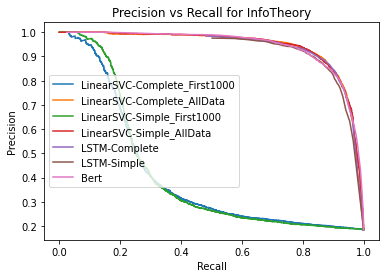

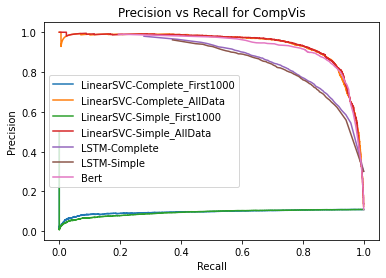

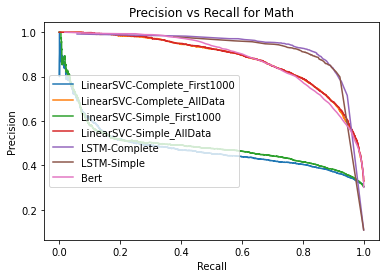

In [ ]:
plot_curves(model_predictions_dict)

We can see the curves for each subject, containing each the 7 different combinations of models. The first 1000 rows versions of the statistical methods are making the plot a little hard to read and their inclusion in the plots is only for presentation purposes, because their performance is not good at all. So we are going to remove these 2 cases of each of the subjects and re-plot, to end up with more legible and prettier plots.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


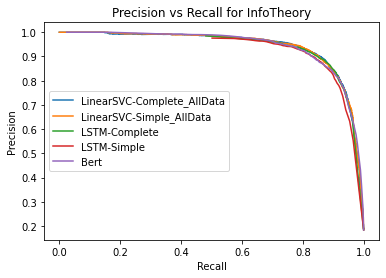

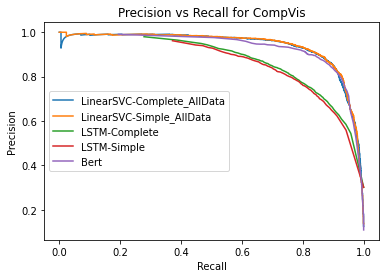

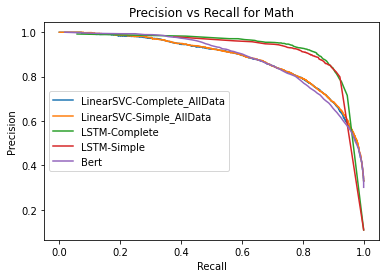

In [ ]:
# removing statistical models trained only on the first 1000 rows 
# from the dictionary and re-plotting
model_predictions_dict_only_all_data = model_predictions_dict.copy()
for subject in model_predictions_dict_only_all_data.keys():
  model_predictions_dict_only_all_data[subject].pop('LinearSVC-Complete_First1000')
  model_predictions_dict_only_all_data[subject].pop('LinearSVC-Simple_First1000')
plot_curves(model_predictions_dict_only_all_data)

Further discussion about the plots will be provided in the Report.

## Part 2: Topic Modelling

### 2.1 Introduction

In this task, we are going to build different LDA models to extract the most recurrent topics in the provided abstracts. In order to do so, we will perform the following steps:

* Try which is the best way to tokenize the abstracts.

* Show preliminar results of LDA modelling without lemmatizing nor removing stop-words.

* Pre-process the abstract using 2 different configurations, in order to be able to compare their results afterwards. The different alternatives imply changes in the inclusion of trigrams, the form of inclusion of bigrams, vectorization with the use of BOW + TF-IDF or only BOW, the selected value for the number of topics, etc.

* Build 2 models per each configuration (with 20K and 1K instances), plot Word-cloud and pyLDavis plot for each combination and calculate the Coherence Score.

* Extract the titles of the k most meaningful abstracts for each topic of each model, which will help us decide if our topics actually make sense or not.

### 2.2 Importing the libraries and loading the data


In [ ]:
import nltk
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim import corpora, models
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
from gensim.models import CoherenceModel
from pprint import pprint
from gensim.models import Phrases
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import MWETokenizer
from itertools import chain
from nltk.probability import *
from nltk.collocations import *

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading the training data and taking a look at it
classification_data = pd.read_csv('axcs_train.csv')
classification_data.head()

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract,Abstract_complete,Abstract_simple
0,cs-9301111,arxiv.org/abs/cs/9301111,1989-12-31,Nested satisfiability,0,0,0,Nested satisfiability A special case of the s...,nested satisfiability special case satisfiabil...,nested satisfiability a special case of the sa...
1,cs-9301112,arxiv.org/abs/cs/9301112,1990-03-31,A note on digitized angles,0,0,0,A note on digitized angles We study the confi...,note digitized angle study configuration pixel...,a note on digitized angles we study the config...
2,cs-9301113,arxiv.org/abs/cs/9301113,1991-07-31,Textbook examples of recursion,0,0,0,Textbook examples of recursion We discuss pro...,textbook example recursion discus property rec...,textbook examples of recursion we discuss prop...
3,cs-9301114,arxiv.org/abs/cs/9301114,1991-10-31,Theory and practice,0,0,0,Theory and practice The author argues to Sili...,theory practice author argues silicon valley i...,theory and practice the author argues to silic...
4,cs-9301115,arxiv.org/abs/cs/9301115,1991-11-30,Context-free multilanguages,0,0,0,Context-free multilanguages This article is a...,context-free multilanguages article sketch ide...,context-free multilanguages this article is a ...


In [ ]:
docs = classification_data.loc[:20000, 'Abstract'].tolist()

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True


### 2.3 General Pre-processing

#### 2.3.1 Trying different ways of tokenizing

We will first try the same regular expression for capturing tokens that we used for the first task: we will keep words, pre-hyphened words (such as state-of-the-art, etc), words containing ' (such as google's) or words unified by an underscore. But this time we will also add numbers, in case we have any interesting alphanumeric token.


In [ ]:
# Split the documents into tokens according to the specified above
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+(?:[-'_][a-zA-Z0-9]+)*'?")
# creating new list as a test, not to change the original one
test_docs = docs.copy()
for idx in range(len(docs)):
    test_docs[idx] = docs[idx].lower()  # Convert to lowercase.
    test_docs[idx] = tokenizer.tokenize(test_docs[idx])  # Split into words.

I will print a few of the tokens containing - ' or _ to see if they make sense:

In [ ]:
# defining a function to re-use while printing tokens with
# - ' or _
def print_char_words(character, no_elements_to_print):
  print_counter = 0
  for i in range(len(test_docs)):
    for token in test_docs[i]:
      if character in token:
        print(token)
        print_counter +=1
      if print_counter == no_elements_to_print:
        break
    if print_counter == no_elements_to_print:
      break

In [ ]:
print_char_words("-", 20)

context-free
context-free
np-complete
market-oriented
well-understood
market-oriented
dependency-directed
hill-climbing
hill-climbing
hill-climbing
nordstrom-robinson
nordstrom-robinson
self-dual
second-order
reed-muller
note-taking
pen-based
button-box
learning-apprentice
self-extracting


In [ ]:
print_char_words("'", 20)

mccarthy's
function'
takeuchi's
author's
gsat's
user's
flow'
subdue's
occam's
turing's
n'
n'
flat'
adults'
evaluation'
peach'
beach'
similar'
katz's
head'


In [ ]:
print_char_words("_", 30)

f_0
f_0
f_0
f_0
f_i
f_i
f_i
f_i
f_j
m_i
f_j
f_i
f_j
m_i
x_i
x_i
max_cut
min_quotient_cut
min_quotient_cut
n_i
omega_1
omega_2
omega_1
omega_k
omega_k
omega_i
prod_i
alpha_i
g_i
alpha_i


We can see that tokens with _ don't make much sense, so we are going to update the regular expression to ignore words with underscore.

#### 2.3.2 The effect of not lemmatizing nor removing stop-words

I will try to build in this part a preliminary LDA model without doing any of those steps, just to prove that the result is not going to be good, which will then confirm that we should include these steps in our pre-processing pipeline.

In [ ]:
# loading the docs again
docs = classification_data.loc[:20000, 'Abstract'].tolist()

In [ ]:
# Again but without underscore
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+(?:[-'][a-zA-Z0-9]+)*'?")
# creating new list as a test, not to change the original one
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

I won't lemmatize nor remove the stop words in this step, also to see what happens:

In [ ]:
# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words shorter than 3 characters
docs = [[token for token in doc if len(token) > 2] for doc in docs]

We define a function to train the LDA model to be able to re-use it every time with different configurations:

In [ ]:
def train_lda_model(docs, topic_no, no_below, no_above, tfidf=False):

    # Create a dictionary representation of the documents.
    dictionary = Dictionary(docs)

    # Filter out words that occur less than certain frequency, or more than x% of the documents.
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    # vectorizing corpus
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    # adding tf-idf to the vectorization of the corpus
    if tfidf == True:
      tfidf = models.TfidfModel(corpus)
      corpus = tfidf[corpus]
    # Set training parameters.
    chunksize = 2000
    passes = 10
    iterations = 200
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        num_topics=topic_no,
        passes=passes,
        eval_every=eval_every
    )
    return model,corpus,dictionary

In [ ]:
# training the model with the previously pre-processed corpus
model = train_lda_model(docs, 8, 200, 0.5)[0]

I will now define a function to plot the topics found by our model in a Word Cloud, which I consider to be an easy way to have a quick look about the results.

In [ ]:
# code retrieved (and slightly modified) from 
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

def plot_word_cloud(model, no_topics):
    if no_topics < 11:
      cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    else:
      cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False, num_topics = no_topics)
    if no_topics >10:
        fig, axes = plt.subplots(4, int(no_topics/4), figsize=(10,10), sharex=True, sharey=True)
    else:
        fig, axes = plt.subplots(2, int(no_topics/2), figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

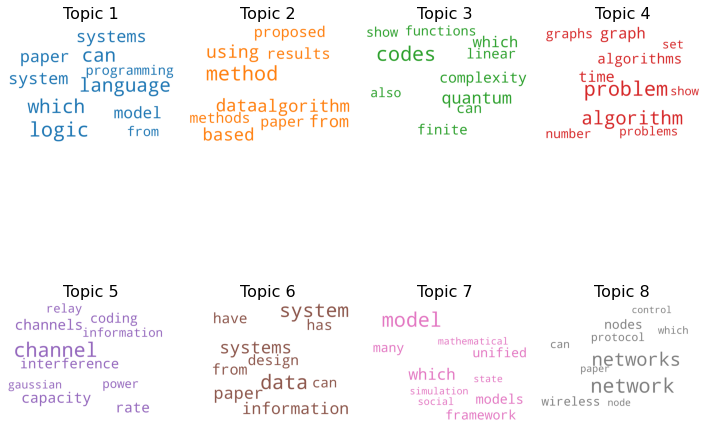

In [ ]:
stop_words = set(stopwords.words('english'))
plot_word_cloud(model, 8)

We can observe that all the topics contain stop-words such as which, our, from, etc that don't add much value to our analysis. We also have different versions of the same words such as network/networks, graph/graphs which is not helpful. That is why we are going to include removing of stop-words and lemmatizing in our pre-processing pipelines.

### 2.4 Model 1 configuration

#### 2.4.1 Model 1 pre-processing

Now starting the pre-processing again we will build our first configuration including eveything we discussed so far:

* Tokenizer including alphanumeric tokens potentially unified by hyphen or apostrophe (Joe's, state-of-the-art)

* convert everything to lowercase

* removing plain numbers (but allowing alphanumeric combinations)

* removing stop-words

* lemmatizing

* adding trigrams and bigrams to the corpus, by replacing the original unigrams from which they are composed

In [ ]:
docs = classification_data.loc[:20000, 'Abstract'].tolist()
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+(?:[-'][a-zA-Z0-9]+)*'?")
# creating new list as a test, not to change the original one
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words shorter than 3 characters
docs = [[token for token in doc if len(token) > 2] for doc in docs]

# Remove stopwords
stop_words = set(stopwords.words('english'))

docs = [[token for token in doc if token not in stop_words] for doc in docs]

# lemmatizing the tokens
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs_1 = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

We are going to add bigams and trigrams as well and re-tokenize them as one single word, in order to replace in the corpus the unigrams from which they are built:

In [ ]:
# finding trigrams (n =3)
trigrams = ngrams(list(chain.from_iterable(docs_1)), n = 3)
top2000_trigrams = FreqDist(trigrams).most_common(2000)
# removing the ones with less than 20 occurrences (a frequency/no_documents) ratio
# of 0.1%
trigram_tuples = [words_tuple for words_tuple, freq in top2000_trigrams if freq >= 20]
# re-tokenizing so that trigrams are one unique token
mwetokenizer = MWETokenizer(trigram_tuples)
for i in range(len(docs_1)):
    docs_1[i] = mwetokenizer.tokenize(docs_1[i])
trigrams_list = [word[0] +'_' + word[1] + '_' + word[2] for word,freq in top2000_trigrams if freq >= 20]
trigrams_list[:15]

['wireless_sensor_network',
 'channel_state_information',
 'simulation_result_show',
 'achievable_rate_region',
 'multiple_access_channel',
 'upper_lower_bound',
 'necessary_sufficient_condition',
 'paper_present_new',
 'multiple-input_multiple-output_mimo',
 'state_information_csi',
 'mobile_hoc_network',
 'result_show_proposed',
 'natural_language_processing',
 'gaussian_interference_channel',
 'signal-to-noise_ratio_snr']

In [ ]:
# analogous procedure but fore bigrams
bigrams = ngrams(list(chain.from_iterable(docs_1)), n = 2)
top2000_bigrams = FreqDist(bigrams).most_common(2000)
bigram_tuples = [words_tuple for words_tuple, freq in top2000_bigrams if freq >= 20]
mwetokenizer = MWETokenizer(bigram_tuples)
for i in range(len(docs_1)):
    docs_1[i] = mwetokenizer.tokenize(docs_1[i])
bigrams_list = [word[0] +'_' + word[1] for word,freq in top2000_bigrams if freq >= 20]
bigrams_list[:15]

['paper_present',
 'lower_bound',
 'upper_bound',
 'wireless_network',
 'special_case',
 'also_show',
 'paper_propose',
 'paper_study',
 'network_coding',
 'neural_network',
 'paper_show',
 'optimization_problem',
 'result_show',
 'capacity_region',
 'paper_describes']

#### 2.4.2 Training first model 

Training the model again with the new pre-processing: we select 8 topics in total, we leave out words with freq less than 200 and words too commun that appear in more than 75% of the documents. We will apply tf-idf (set to True in the last parameter).

In [ ]:
model_1, corpus_1, dictionary_1 = train_lda_model(docs_1, 10, 200, 0.75, True)

#### 2.4.3 First model results

As we did before, we first print the Word-cloud of the trained model to get a preliminar grasp of what is going on.

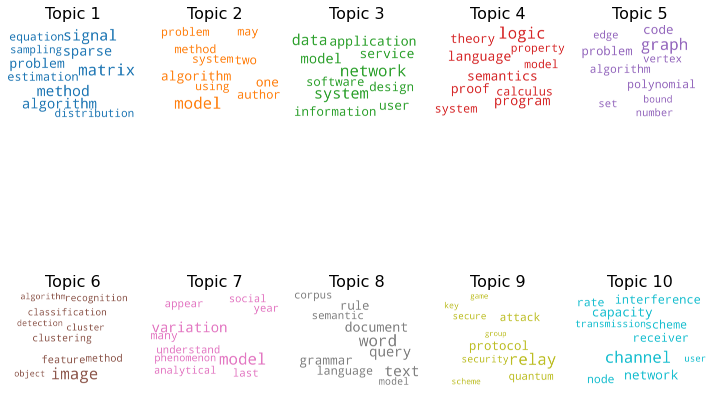

In [ ]:
word_cloud_model_1 = plot_word_cloud(model_1, 10)
word_cloud_model_1

We can see that now the key words of each topic are much more meaningful than when we hadn't lemmatized nor removed the stop-words. Another way to look at this could be by seeing the weights of the most meaningful words for each topic, as follows:

In [ ]:
for id, topic in model_1.print_topics(-1):
    print(f"TOPIC: {id+1} \n WORDS: {topic}")

TOPIC: 1 
 WORDS: 0.009*"matrix" + 0.008*"signal" + 0.007*"method" + 0.007*"algorithm" + 0.007*"sparse" + 0.006*"problem" + 0.006*"estimation" + 0.006*"equation" + 0.006*"distribution" + 0.005*"sampling"
TOPIC: 2 
 WORDS: 0.006*"model" + 0.004*"algorithm" + 0.004*"one" + 0.004*"two" + 0.003*"author" + 0.003*"may" + 0.003*"method" + 0.003*"problem" + 0.003*"system" + 0.003*"using"
TOPIC: 3 
 WORDS: 0.007*"network" + 0.007*"system" + 0.006*"data" + 0.005*"model" + 0.005*"application" + 0.005*"service" + 0.005*"user" + 0.004*"information" + 0.004*"design" + 0.004*"software"
TOPIC: 4 
 WORDS: 0.012*"logic" + 0.008*"program" + 0.008*"language" + 0.008*"semantics" + 0.008*"proof" + 0.007*"theory" + 0.006*"system" + 0.006*"calculus" + 0.006*"model" + 0.006*"property"
TOPIC: 5 
 WORDS: 0.015*"graph" + 0.009*"code" + 0.008*"problem" + 0.007*"polynomial" + 0.007*"algorithm" + 0.006*"vertex" + 0.006*"set" + 0.006*"edge" + 0.006*"number" + 0.005*"bound"
TOPIC: 6 
 WORDS: 0.030*"image" + 0.010*"fea

But this remains still a little too basic. In order to dig deeper, we are going to use the pyLDavis library, which will give us a detailed information about the key words in the different topics, the relative distances between topics, etc...

## IF YOU ARE NOT ABLE TO VISUALIZE THE LDA VIS IN JUPYTER NOTEBOOK PLEASE OPEN THE FILE IN COLAB, YOU WON'T HAVE ANY TROUBLE THERE. THANK YOU!

In [ ]:
!pip install pyLDAvis==2.1.2
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model_1, corpus_1, dictionary_1, sort_topics=False)
pyLDAvis.display(lda_display)

     |████████████████████████████████| 1.6MB 16.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=f222fe3e3bcc2002d8d1b06c37a04c451a8dd5d566a8929982bd54252def5ad0
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# printing model coherence, which is a measure of how well our model is doing (between 0 and 1, the higher the better)
# the number is not great but is not terrible either.
# I print it mainly to be able to compare between the 2 different configurations
model_coherence = CoherenceModel(model=model_1, texts= docs_1, dictionary = dictionary_1, coherence = "c_v")
model_coherence_score_1 = model_coherence.get_coherence()
print("Coherence Score:", model_coherence_score_1)

Coherence Score: 0.4582452558920426


Further analysis about this visualization will be provided in the report.

#### 2.4.4 First model with only 1000 instances

Now let's try the same thing but with the first 1000 rows of data. The good thing is that we have already done all the pre-processing, the only thing left to do is to subset the processed docs list. We will plot the Word-cloud, retrieve the weights of the key words and plot the pyLDavis plot.

In [ ]:
docs_first_1000 = docs_1[:1000]

In [ ]:
# train the model
# we lower the no_below threshold from 200 to 10 because we have much less data now
model_1_first1000, corpus_1_first1000, dictionary_1_first1000 = train_lda_model(docs_first_1000, 10, 10, 0.75, True)

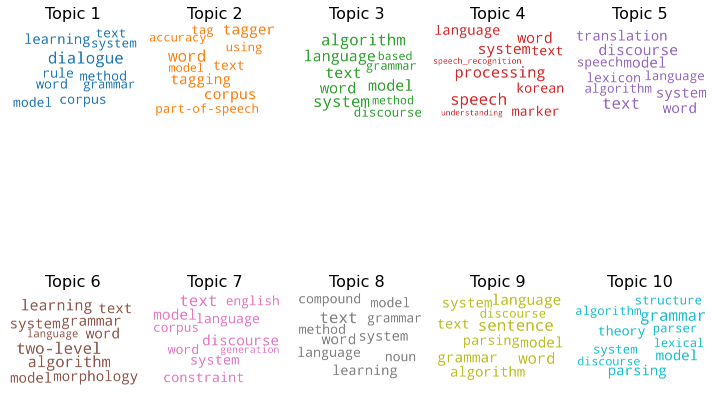

In [ ]:
plot_word_cloud(model_1_first1000, 10)

We already see here that all the topics are talking about the same things: grammar, language, corpus, etc. Maybe the data is ordered by topic (NLP in this case or something like that) and by getting the first 1000 we only got these kinds of articles. Further analysis will be provided in the report, but the synthetic thing to say is that this cannot be good.

In [ ]:
for id, topic in model_1_first1000.print_topics(-1):
    print(f"TOPIC: {id+1} \n WORDS: {topic}")

TOPIC: 1 
 WORDS: 0.005*"dialogue" + 0.004*"learning" + 0.004*"corpus" + 0.004*"rule" + 0.004*"word" + 0.004*"model" + 0.004*"method" + 0.003*"text" + 0.003*"system" + 0.003*"grammar"
TOPIC: 2 
 WORDS: 0.006*"word" + 0.005*"tagger" + 0.005*"corpus" + 0.005*"tagging" + 0.004*"text" + 0.004*"tag" + 0.004*"part-of-speech" + 0.004*"using" + 0.003*"accuracy" + 0.003*"model"
TOPIC: 3 
 WORDS: 0.003*"system" + 0.003*"algorithm" + 0.003*"text" + 0.003*"model" + 0.003*"word" + 0.003*"language" + 0.003*"discourse" + 0.003*"grammar" + 0.003*"method" + 0.002*"based"
TOPIC: 4 
 WORDS: 0.005*"speech" + 0.004*"processing" + 0.004*"word" + 0.004*"system" + 0.004*"language" + 0.003*"text" + 0.003*"korean" + 0.003*"marker" + 0.003*"speech_recognition" + 0.003*"understanding"
TOPIC: 5 
 WORDS: 0.005*"text" + 0.004*"discourse" + 0.004*"model" + 0.004*"system" + 0.004*"word" + 0.004*"translation" + 0.003*"lexicon" + 0.003*"speech" + 0.003*"language" + 0.003*"algorithm"
TOPIC: 6 
 WORDS: 0.004*"two-level" +

In [ ]:
lda_display = pyLDAvis.gensim.prepare(model_1_first1000, corpus_1_first1000, dictionary_1_first1000, sort_topics=False)
pyLDAvis.display(lda_display)

We can see that the result is considerably worse than with 20000, as seen in the Word-cloud, as the topics are all discussing very similar things.



### 2.5 Model 2 configuration

Now I will do the analogous procedure for with the following changes:

* Alpha-numeric tokens will be removed.
* We will not keep trigrams, only bigrams.
* Bigrams will be appended to the list of tokens, meaning that they will not replace the words that conform it but we will be keeping all 3 tokens(if we have machine and learning forming machine_learning we will keep the 3).
* Number of topics will be increased to 20 (from 10 in the previous case).
* Allowed document frequency will be reduced to 30% (from 75 in the previous case).
* Vectorization will be implemented only with Bag Of Words (without TD-IDF like before).

#### 2.5.1 Pre-processing model 2

In [ ]:
docs = classification_data.loc[:20000, 'Abstract'].tolist()

In [ ]:
# Again but without alpha-numeric tokens
tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)*'?")
# creating new list as a test, not to change the original one
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

In [ ]:
# This part is the same as before
docs = [[token for token in doc if len(token) > 2] for doc in docs]

# Remove stopwords
stop_words = set(stopwords.words('english'))

docs = [[token for token in doc if token not in stop_words] for doc in docs]

# lemmatizing the tokens

lemmatizer = WordNetLemmatizer()
docs_2 = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [ ]:
# Add bigrams that appear 20 times or more, this time appending not replacing
bigram = Phrases(docs_2, min_count=20)
bigram_list = []
for idx in range(len(docs_2)):
    for token in bigram[docs_2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs_2[idx].append(token)
            if token not in bigram_list:
              bigram_list.append(token)
# print first 15 appearing bigrams, to check them out
bigram_list[:15]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['special_case',
 'satisfiability_problem',
 'hierarchical_structure',
 'straight_line',
 'open_question',
 'computer_science',
 'software_development',
 'context-free_language',
 'keep_track',
 'programming_language',
 'certain_condition',
 'decision_making',
 'resource_allocation',
 'decision_process',
 'search_tree']

#### 2.5.2 Training model 2

In [ ]:
# topics = 20
# min_word_count = 200
# max doc_frequency = 30%
# tf-idf = False, only BOW
model_2, corpus_2, dictionary_2 = train_lda_model(docs_2, 20, 200, 0.3, False)

#### 2.5.3 Model 2 results

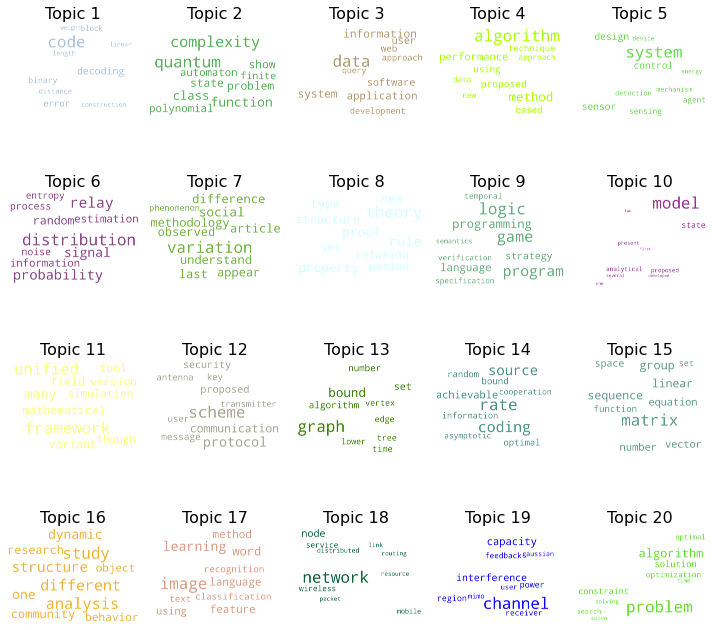

In [ ]:
word_cloud_model_2 = plot_word_cloud(model_2, 20)
word_cloud_model_2

In [ ]:
for id, topic in model_2.print_topics(-1):
    print(f"TOPIC: {id+1} \n WORDS: {topic}")

TOPIC: 1 
 WORDS: 0.231*"code" + 0.055*"decoding" + 0.045*"error" + 0.037*"binary" + 0.030*"block" + 0.026*"distance" + 0.024*"length" + 0.022*"construction" + 0.020*"linear" + 0.018*"weight"
TOPIC: 2 
 WORDS: 0.039*"quantum" + 0.035*"complexity" + 0.025*"function" + 0.022*"class" + 0.019*"state" + 0.019*"show" + 0.018*"problem" + 0.018*"polynomial" + 0.018*"automaton" + 0.015*"finite"
TOPIC: 3 
 WORDS: 0.050*"data" + 0.020*"information" + 0.020*"system" + 0.019*"application" + 0.017*"software" + 0.016*"user" + 0.013*"web" + 0.012*"approach" + 0.011*"development" + 0.010*"query"
TOPIC: 4 
 WORDS: 0.058*"algorithm" + 0.033*"method" + 0.023*"performance" + 0.018*"proposed" + 0.017*"using" + 0.016*"based" + 0.015*"technique" + 0.012*"approach" + 0.011*"new" + 0.011*"data"
TOPIC: 5 
 WORDS: 0.167*"system" + 0.036*"design" + 0.035*"sensor" + 0.035*"control" + 0.023*"sensing" + 0.022*"agent" + 0.016*"detection" + 0.016*"mechanism" + 0.013*"device" + 0.013*"energy"
TOPIC: 6 
 WORDS: 0.042*"di

In [ ]:
lda_display_2 = pyLDAvis.gensim.prepare(model_2, corpus_2, dictionary_2, sort_topics=False)
pyLDAvis.display(lda_display_2)

In [ ]:
model_coherence = CoherenceModel(model=model_2, texts= docs_2, dictionary = dictionary_2, coherence = "c_v")
model_coherence_score_2 = model_coherence.get_coherence()
print("Coherence Score:", model_coherence_score_2)

Coherence Score: 0.45517656517114774


The topics here also seem pretty reasonable. One positive thing about these models is that the topics are more evenly spread and not as clustered as the previous ones, both for the 20K and 1K cases. This is due, I believe, to the use of BOW instead of TF-IDF and also because of the increase in K (more details provided in the report).

Bigrams in this case appear several times with their composition unigrams among the key words, which I believe is not good because it represents duplicate information. This was not happening in the previous model.

#### 2.5.4 First 1000 instances version of Model 2

In [ ]:
# Same thing but for the case of the first 1000 extracts:
docs_2_first1000 = docs_2[:1000]
model_2_first1000, corpus_2_first1000, dictionary_2_first1000 = train_lda_model(docs_2_first1000, 20, 10, 0.3, False)
lda_display_2_first1000 = pyLDAvis.gensim.prepare(model_2_first1000, corpus_2_first1000, dictionary_2_first1000, sort_topics=False)
pyLDAvis.display(lda_display_2_first1000)

Same thing in this case: a lot of repeated words among topics.

### 2.6 Most meaningful abstracts

In the following section we are going to print the most meaningful article titles for each topic in each model to help us identify if there is a clear relationship between the words in each topic.

We will be defining the following functions to achieve this (the first one was extracted from the tutorial materials and the other 2 were written by me):

In [ ]:
# function extracted from Tutorial Material that returns a data frame containing
# each article and a classification of which is the dominant topic in the article,
# with a contribution percentage (if the percentage is higher, it means that the
# article is more likely to be discussing that particular topic)

def get_document_topics(ldamodel, corpus, texts):
   # Init output
    document_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    document_topics_df = pd.concat([document_topics_df, contents], axis=1)

    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text']

    return document_topics_df

In [ ]:
# Function built by me, to retrieve a data frame containing the top k
# articles of each topic

def get_top_k_df(model_topics, k):
  # create a data frame to store the topics
  top_k_df = pd.DataFrame()
  # loop over each topic
  for topic in model_topics.Dominant_Topic.unique():
    # subset with each topic
    model_topics_subset = model_topics[model_topics.Dominant_Topic==topic]
    # sort values by the contribution to. the topic
    model_topics_subset_ordered = model_topics_subset.sort_values(by='Perc_Contribution', ascending = False)
    # only keep the first k
    models_topics_top_k = model_topics_subset_ordered.iloc[:k,0:]
    # concatenate all the results from each loop refering to each topic together
    top_k_df = pd.concat([top_k_df, models_topics_top_k], ignore_index = True)
  return top_k_df

In [ ]:
# Function also defined by me to retrieve a dictionary with topic as key and
# a list for the titles for the k most meaningful articles for each topic as values

def retrieve_text_title(top_k_df):
  # creating the dict that will be returned
  top_k_titles_dict = dict()
  # rename column of the data frame retrieved by the previous function to be 
  # able to merge it with original data in order to retrieve titles
  top_k_df = top_k_df.rename(columns={'Original_Text':'Abstract'})
  top_k_df_merge = pd.merge(top_k_df, classification_data, on = 'Abstract')
  # looping over each topic
  for topic in top_k_df_merge.Dominant_Topic.unique():
    # subsetting each topic
    top_k_df_subset = top_k_df_merge[top_k_df_merge.Dominant_Topic == topic]
    # reseting index to be able to capture with index 0
    top_k_df_subset = top_k_df_subset.reset_index(drop=True)
    # looping over the k articles of each topic
    for i in range(len(top_k_df_subset)):
        # if it's the first article, create the values list and append the title
        if i == 0:
            top_k_titles_dict[int(topic +1)] = []
            top_k_titles_dict[int(topic +1)].append(top_k_df_subset.loc[i, 'Title'])
        else:
          # append the title of the article
          top_k_titles_dict[int(topic +1)].append(top_k_df_subset.loc[i, 'Title'])
  return(top_k_titles_dict)

For each model we are going to print the word-cloud plot next to the dictionary containing the top k abstracts titles, to be able to better see the connections.

For the 20K versions, we will print the 5 most meaningful while for the 1K versions only the first 2

#### 2.6.1 Most meaningful abstracts Model 1

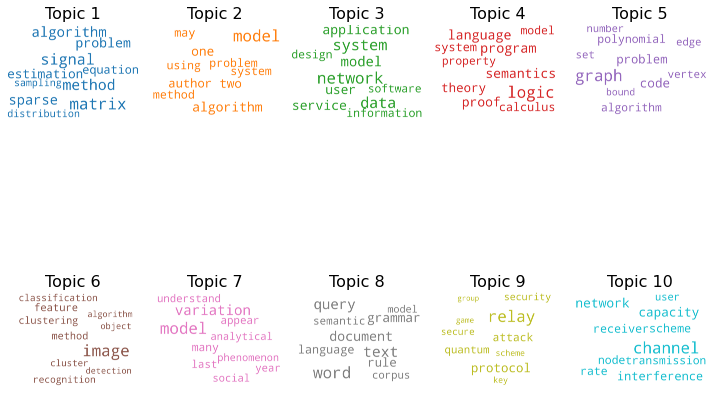

In [ ]:
word_cloud_model_1 = plot_word_cloud(model_1, 10)
word_cloud_model_1

In [ ]:
model_1_topics = get_document_topics(model_1, corpus_1, classification_data.loc[:20000, 'Abstract'].tolist())
top_k_df_model_1 = get_top_k_df(model_1_topics, 5)
dict_model_1_topics = retrieve_text_title(top_k_df_model_1)
dict_model_1_topics

{1: ['Learning Multiple Belief Propagation Fixed Points for Real Time Inference',
  'Probabilistic Inference from Arbitrary Uncertainty using Mixtures of Factorized Generalized Gaussians',
  'Improved RANSAC performance using simple  iterative minimal-set solvers',
  'Topics in Compressed Sensing',
  'Information field theory for cosmological perturbation reconstruction and non-linear signal analysis'],
 2: ['Statistics and implementation of APRNGs',
  'Exchangeable equilibria contradict exactness of the Papadimitriou-Roughgarden algorithm',
  'Wiretap Channel With Side Information',
  'Pervasive Emotions in Pervasive Computing Environments'],
 3: ['Dependability in Aggregation by Averaging',
  'Astronomy in the Cloud: Using MapReduce for Image Coaddition',
  'Efficient Multi-site Data Movement Using Constraint Programming for Data Hungry Science',
  'A Modular and Fault-Tolerant Data Transport Framework',
  'Reinforcement Learning in BitTorrent Systems'],
 4: ['Definition and Implemen

We can already start to relate topics: for example topic 5 could be related to Graph Theory  or Topic 9 to cyber-security, and so on.

And for the case of first 1000 rows:

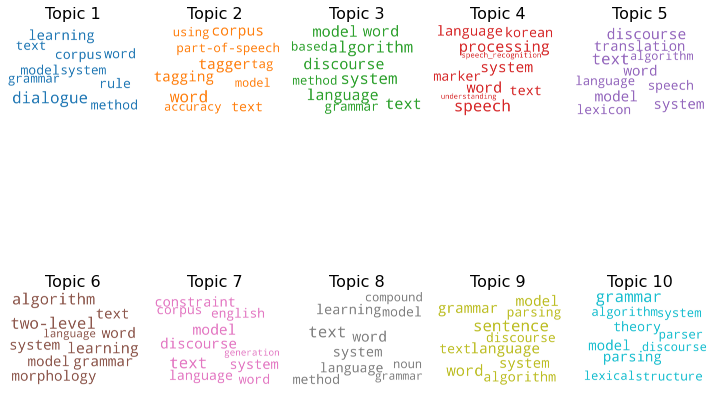

In [ ]:
word_cloud_model_1_first1000 = plot_word_cloud(model_1_first1000, 10)
word_cloud_model_1_first1000

In [ ]:
model_1_first1000_topics = get_document_topics(model_1_first1000, corpus_1_first1000, classification_data.loc[:1000, 'Abstract'].tolist())
top_k_df_model_1_first1000 = get_top_k_df(model_1_first1000_topics, 2)
dict_model_1_first1000_topics = retrieve_text_title(top_k_df_model_1_first1000)
dict_model_1_first1000_topics

{1: ['Using Multiple Sources of Information for Constraint-Based Morphological Disambiguation',
  'Combining Hand-crafted Rules and Unsupervised Learning in Constraint-based Morphological Disambiguation'],
 2: ['Does Baum-Welch Re-estimation Help Taggers?',
  'Tagging French Without Lexical Probabilities -- Combining Linguistic Knowledge And Statistical Learning'],
 3: ['Empirical Discovery in Linguistics',
  'The complexity of normal form rewrite sequences for Associativity'],
 4: ['Chart-driven Connectionist Categorial Parsing of Spoken Korean',
  "Speech Repairs  Intonational Boundaries and Discourse Markers: Modeling Speakers' Utterances in Spoken Dialog"],
 5: ['Wrap-Up: a Trainable Discourse Module for Information Extraction',
  'Cue Phrase Classification Using Machine Learning',
  'Cue Phrase Classification Using Machine Learning'],
 6: ['Learning Features that Predict Cue Usage',
  'Natural Language Generation in Healthcare: Brief Review'],
 7: ['Nonuniform Markov models', 'Hie

All the articles seem to be treating the same subjects related to NLP, as seen in the Word-cloud.

#### 2.6.1 Most meaningful abstracts Model 2

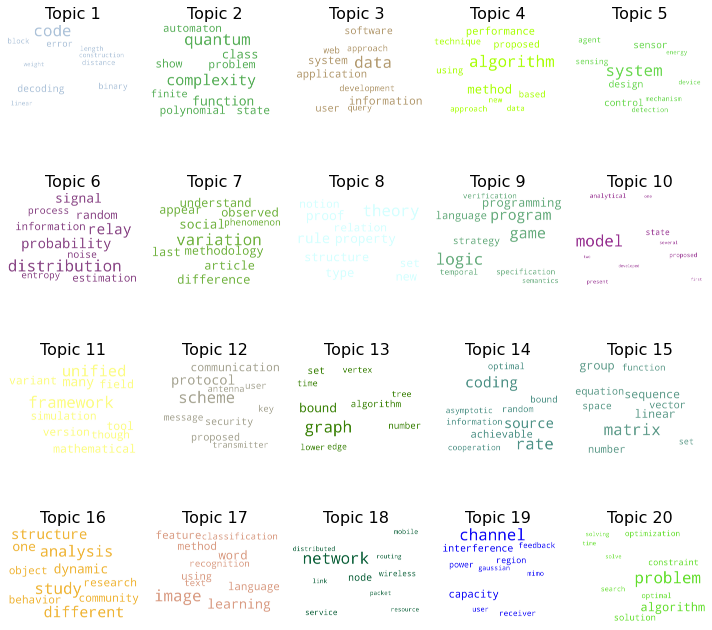

In [ ]:
word_cloud_model_2 = plot_word_cloud(model_2, 20)
word_cloud_model_2

In [ ]:
model_2_topics = get_document_topics(model_2, corpus_2, classification_data.loc[:20000, 'Abstract'].tolist())
top_k_df_model_2 = get_top_k_df(model_2_topics, 5)
dict_model_2_topics = retrieve_text_title(top_k_df_model_2)
dict_model_2_topics

{1: ['New Construction of A Family of Quasi-Twisted Two-Weight Codes',
  'New Construction of 2-Generator Quasi-Twisted Codes',
  'New Constructions of a Family of 2-Generator Quasi-Cyclic Two-Weight Codes and Related Codes',
  'New Quasi-Cyclic Codes from Simplex Codes',
  'Cumulative-Separable Codes'],
 2: ['Tally NP Sets and Easy Census Functions',
  'Nondeterministic fuzzy automata',
  'Self-Specifying Machines',
  'Transition Complexity of Incomplete DFAs',
  'Answers to Questions Formulated in the Paper "On States Observability in Deterministic Finite Automata"'],
 3: ['Collaborative Knowledge Creation and Management in Information Retrieval',
  'A Case for A Collaborative Query Management System',
  'FPGA based Agile Algorithm-On-Demand Co-Processor',
  'Mragyati : A System for Keyword-based Searching in Databases',
  "Personnalisation de Syst\\`emes OLAP Annot\\'es"],
 4: ['Operand Folding Hardware Multipliers',
  'Attribute Value Weighting in K-Modes Clustering',
  'High-perfo

Here we can also start to relate the topics. The 2 topics we mentioned above as an example for the model 1 also appear here: Topic 12 could be something to do with Cyber-Security and Topic 13 something with Graph Theory.

Now the last results, for 1 K model 2 version:

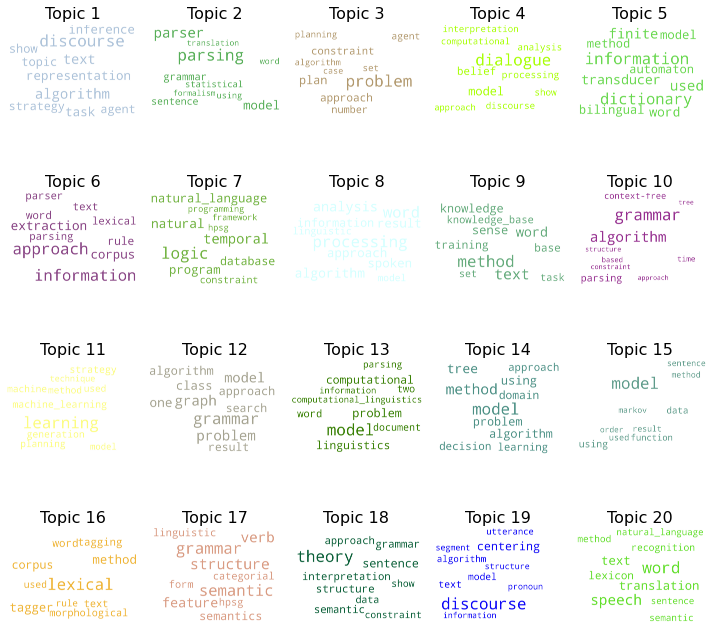

In [ ]:
word_cloud_model_2_first1000 = plot_word_cloud(model_2_first1000, 20)
word_cloud_model_2_first1000

In [ ]:
model_2_topics_first1000 = get_document_topics(model_2_first1000, corpus_2_first1000, classification_data.loc[:1000, 'Abstract'].tolist())
top_k_df_model_2_first1000 = get_top_k_df(model_2_topics_first1000, 2)
dict_model_2_topics_first1000 = retrieve_text_title(top_k_df_model_2_first1000)
dict_model_2_topics_first1000

{1: ['Lower bounds for identifying subset members with subset queries',
  'Integrating Text Plans for Conciseness and Coherence'],
 2: ['Maximum Entropy Modeling Toolkit',
  'Word-to-Word Models of Translational Equivalence'],
 3: ['Flexibly Instructable Agents', 'Collaborating on Referring Expressions'],
 4: ['DIA-MOLE: An Unsupervised Learning Approach to Adaptive Dialogue Models for Spoken Dialogue Systems',
  'Incremental Interpretation: Applications  Theory  and Relationship to Dynamic Semantics'],
 5: ['Mechanisms for Automated Negotiation in State Oriented Domains',
  'Disambiguating bilingual nominal entries against WordNet'],
 6: ['Combining Hand-crafted Rules and Unsupervised Learning in Constraint-based Morphological Disambiguation',
  'Using Multiple Sources of Information for Constraint-Based Morphological Disambiguation'],
 7: ['Time  Tense and Aspect in Natural Language Database Interfaces',
  'Provably Bounded-Optimal Agents'],
 8: ['SCREEN: Learning a Flat Syntactic an

We can see the same thing happening here in which almost all of the topics discuss language.

### References

* Updated Sentiment Analysis. GitHub. Retrieved from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb

* Topic Modelling Visualization. How to present the results of LDA models? Selva Prabhakaran. Retrieved from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/